In [1]:
import pysr
from pysr import PySRRegressor

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [1]:
import sys
import os

from pathlib import Path
import glob
workdir = os.getenv("PATH_TO_PARTGP")
sys.path.append(workdir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import uproot
import awkward as ak
import copy
import shutil
import fastjet

from weaver.utils.import_tools import import_module
from weaver.utils.dataset import SimpleIterDataset
from weaver.utils.nn.tools import evaluate_classification, train_classification
from weaver.utils.logger import _logger, warn_n_times

from utils.nn_utils.part_prediction import test_load, train_load, knowledge_distillation, optim
from utils.nn_utils.hook_handler import HookHandler

import analysis_tools.metrics as metrics
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from scipy.special import softmax

import mplhep as mh

plt.style.use(mh.style.CMS)

ModuleNotFoundError: No module named 'utils.nn_utils.part_prediction'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_datasets = os.getenv("PART_DATA")

In [ ]:
class Args:
    def __init__(self, **kwargs):
        # defaults
        self.data_train = []
        self.data_test = []
        self.data_val = []
        self.num_workers = 0
        self.num_epochs = 0
        self.data_config = ''
        self.extra_selection = None
        self.extra_test_selection = None
        self.file_fraction = 1
        self.data_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.batch_size = 0
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.demo = False
        self.no_remake_weights = False
        self.steps_per_epoch = None
        self.steps_per_epoch_val = None
        self.backend = None
        self.model_prefix = None
        self.lr_finder = None
        self.optimizer_option = []
        self.optimizer = 'ranger'
        self.start_lr = 1e-3
        self.final_lr = 1e-6
        self.lr_scheduler = 'flat+decay'
        self.load_epoch = None
        self.gpus = 0
        self.predict_gpus = 0
        self.regression_mode = False
        self.kl_weight = 0.1
        self.class_weight = 1.0
        
        for key, value in kwargs.items():
            setattr(self, key, value)

In [ ]:
yaml_config = workdir + '/data_config/JetClass/JetClass_kin.yaml'
network_path = workdir + '/models/networks/part_wrapper.py'

jc_paths = {
    'train': path_datasets+'/JetClass/Pythia/train_100M',
    'val': path_datasets+'/JetClass/Pythia/val_5M',
    'test': path_datasets+'/JetClass/Pythia/test_20M'
}

num_classes = 2
signal = '/TTBar_*.root'
background = '/ZJetsToNuNu_*.root'

datasets = {}

for name, path in jc_paths.items():

    if isinstance(signal, str):
        signal_files = glob.glob(path+signal)

    if isinstance(background, str):
        background_files = glob.glob(path+background)

    datasets[name] = signal_files + background_files

complexity = {
    'particle_attn': 2,
    'class_attn': 1
}

In [ ]:
def initialize_models(network_path, config_path, training = True, model_path = None) -> dict:

    models = {}
    
    network_module = import_module(network_path, name='_network_module')
    data_config = SimpleIterDataset({}, config_path, for_training=training).config
    model, model_info = network_module.get_model(data_config, num_layers = complexity['particle_attn'], num_cls_layers = complexity['class_attn'])

    if model_path is not None:
        wts = torch.load(model_path, map_location = 'cpu', weights_only = True)
        model.load_state_dict(wts)
    
    model_metadata = {
        'model': model,
        'info': model_info,
        'loss': network_module.get_loss(data_config)
    }

    return model_metadata

In [ ]:
metadata = initialize_models(network_path, yaml_config, training=True)

In [ ]:
args = Args(
    data_train = datasets['train'],
    data_val = datasets['val'],
    data_test = datasets['test'],
    data_config = yaml_config,
    num_epochs = 5,
    batch_size = 64,
    model_prefix = workdir + '/models/torch_saved/ParT',
    file_fraction = 1,
    data_fraction = 0.01
)

In [ ]:
train_loader, val_loader, data_config, train_input_names, train_label_names = train_load(args)

In [ ]:
model = copy.deepcopy(metadata['model']).to(device)
loss_func = metadata['loss']

In [ ]:
# optimizer & learning rate
opt, scheduler = optim(args, model, device)

In [113]:
tb = None

# training loop
best_valid_metric = np.inf if args.regression_mode else 0
grad_scaler = torch.amp.GradScaler("cuda")
for epoch in range(args.num_epochs):
    if args.load_epoch is not None:
        if epoch <= args.load_epoch:
            continue
    _logger.info('-' * 50)
    _logger.info('Epoch #%d training' % epoch)
    train_classification(model, loss_func, opt, scheduler, train_loader, device, epoch,
          steps_per_epoch=args.steps_per_epoch, grad_scaler=grad_scaler, tb_helper=tb)
    if args.model_prefix and (args.backend is None or local_rank == 0):
        dirname = os.path.dirname(args.model_prefix)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)
        state_dict = model.module.state_dict() if isinstance(
            model, (torch.nn.DataParallel, torch.nn.parallel.DistributedDataParallel)) else model.state_dict()
        torch.save(state_dict, args.model_prefix + '_epoch-%d_state.pt' % epoch)
        torch.save(opt.state_dict(), args.model_prefix + '_epoch-%d_optimizer.pt' % epoch)
    # if args.backend is not None and local_rank == 0:
    # TODO: save checkpoint
    #     save_checkpoint()

    _logger.info('Epoch #%d validating' % epoch)
    valid_metric = evaluate_classification(model, val_loader, device, epoch, loss_func=loss_func,
                            steps_per_epoch=args.steps_per_epoch_val, tb_helper=tb)
    is_best_epoch = (
        valid_metric < best_valid_metric) if args.regression_mode else(
        valid_metric > best_valid_metric)
    if is_best_epoch:
        best_valid_metric = valid_metric
        if args.model_prefix and (args.backend is None or local_rank == 0):
            shutil.copy2(args.model_prefix + '_epoch-%d_state.pt' %
                         epoch, args.model_prefix + '_best_epoch_state.pt')
            # torch.save(model, args.model_prefix + '_best_epoch_full.pt')
    _logger.info('Epoch #%d: Current validation metric: %.5f (best: %.5f)' %
                 (epoch, valid_metric, best_valid_metric), color='bold')

0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/utils/nn/tools.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=grad_scaler is not None):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
3125it [03:09, 16.51it/s, lr=1.00e-03, Loss=0.20130, AvgLoss=0.24657, Acc=0.89062, AvgAcc=0.89878]
0it [00:00, ?it/s]

=== Restarting DataIter val, seed=None ===


156it [00:02, 53.80it/s, Loss=0.28080, AvgLoss=0.23593, Acc=0.84375, AvgAcc=0.90375]
ERROR:weaver:y should be a 1d array, got an array of shape (9984, 2) instead.
0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/utils/nn/tools.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=grad_scaler is not None):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
3125it [02:58, 17.46it/s, lr=1.00e-03, Loss=0.43934, AvgLoss=0.21750, Acc=0.84375, AvgAcc=0.91058]
0it [00:00, ?it/s]

=== Restarting DataIter val, seed=None ===


156it [00:02, 62.18it/s, Loss=0.20616, AvgLoss=0.21126, Acc=0.90625, AvgAcc=0.91697]
ERROR:weaver:y should be a 1d array, got an array of shape (9984, 2) instead.
0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/utils/nn/tools.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=grad_scaler is not None):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
3125it [02:57, 17.61it/s, lr=1.00e-03, Loss=0.17167, AvgLoss=0.20683, Acc=0.90625, AvgAcc=0.91546]
0it [00:00, ?it/s]

=== Restarting DataIter val, seed=None ===


156it [00:02, 57.30it/s, Loss=0.24229, AvgLoss=0.19774, Acc=0.89062, AvgAcc=0.91737]
ERROR:weaver:y should be a 1d array, got an array of shape (9984, 2) instead.
0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/utils/nn/tools.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=grad_scaler is not None):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
3125it [02:57, 17.66it/s, lr=1.00e-03, Loss=0.23893, AvgLoss=0.20356, Acc=0.90625, AvgAcc=0.91668]
0it [00:00, ?it/s]

=== Restarting DataIter val, seed=None ===


156it [00:02, 57.42it/s, Loss=0.26972, AvgLoss=0.19753, Acc=0.92188, AvgAcc=0.92017]
ERROR:weaver:y should be a 1d array, got an array of shape (9984, 2) instead.
0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/utils/nn/tools.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=grad_scaler is not None):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
3125it [02:56, 17.66it/s, lr=1.00e-05, Loss=0.13857, AvgLoss=0.19105, Acc=0.93750, AvgAcc=0.92227]
0it [00:00, ?it/s]

=== Restarting DataIter val, seed=None ===


156it [00:02, 52.60it/s, Loss=0.16145, AvgLoss=0.19193, Acc=0.90625, AvgAcc=0.92358]
ERROR:weaver:y should be a 1d array, got an array of shape (9984, 2) instead.


In [114]:
'''
Generating the SR Dataset
'''

# Batch Size 64, 5 epochs, LR 1e-003, ranger optimizer, 0.1 file fraction, 0.01 data fraction, 16 particles per jet
base_path = workdir + '/models/torch_saved/ParT_epoch-4_state.pt' 

kd_path = workdir + '/models/torch_saved/student_models/ParT_student_1_7_epoch-4_state.pt' 

base_metadata = initialize_models(network_path, yaml_config, training=False, model_path = base_path)
kd_metadata = initialize_models(network_path, yaml_config, training=False, model_path = kd_path)

In [115]:
base_model = copy.deepcopy(base_metadata['model']).to(device)
kd_model = copy.deepcopy(kd_metadata['model']).to(device)

In [116]:
hook_manager = {
    'forward_hooks': {
        'logits': 'fc'
    },
    'pre_forward_hooks': {
        'inputs': 'trimmer'
    }
}

In [117]:
base_handles, base_outputs = HookHandler(base_model, hook_manager).registration(safety_remove = True)
kd_handles, kd_outputs = HookHandler(kd_model, hook_manager).registration(safety_remove = True)


Removing all hooks within the model

Forward Hook Registered: logits

Forward Hook Registered: inputs

Removing all hooks within the model

Forward Hook Registered: logits

Forward Hook Registered: inputs


In [131]:
pred_args = Args(
    data_test = datasets['train'],
    data_config = yaml_config,
    batch_size = 64,
    file_fraction = 1,
    data_fraction = 0.01
)

test_loaders, data_config = test_load(pred_args)

In [132]:
# Base

for name, get_test_loader in test_loaders.items():
    
    test_loader = get_test_loader()
    
    base_metric, base_scores, base_labels, base_observers = evaluate_classification(base_model, test_loader, device, epoch=None, for_training=False)
    
    del test_loader


# KD Student
for name, get_test_loader in test_loaders.items():
    
    test_loader = get_test_loader()
    
    kd_test_metric, kd_scores, kd_labels, kd_observers = evaluate_classification(kd_model, test_loader, device, epoch=None, for_training=False)
    
    del test_loader

0it [00:00, ?it/s]

=== Restarting DataIter test_, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
3125it [03:29, 14.94it/s, Loss=0.00000, AvgLoss=0.00000, Acc=0.95312, AvgAcc=0.92505]
ERROR:weaver:y should be a 1d array, got an array of shape (200000, 2) instead.
0it [00:00, ?it/s]/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/

=== Restarting DataIter test_, seed=None ===


3125it [03:25, 15.19it/s, Loss=0.00000, AvgLoss=0.00000, Acc=0.93750, AvgAcc=0.92226]
ERROR:weaver:y should be a 1d array, got an array of shape (200000, 2) instead.


In [120]:
outputs['forward_hooks']['logits'][0].shape

torch.Size([64, 2])

In [61]:
outputs['pre_forward_hooks']['inputs'][0][1].shape

torch.Size([32, 4, 64])

In [62]:
concat_logits = torch.cat(outputs['forward_hooks']['logits'])

In [71]:
base_logits = torch.cat(base_outputs['forward_hooks']['logits']).cpu().numpy()
kd_logits = torch.cat(kd_outputs['forward_hooks']['logits']).cpu().numpy()

In [64]:
inputs = outputs['pre_forward_hooks']['inputs']

In [86]:
# (n_iterations, n_vectors, batch_size, n_features, n_particles)

# Primary Features, Vectors

In [87]:
concat_inputs = []

for v in range(3):
    if inputs[0][v] is None:
        continue
    
    concat_inputs.append(
        torch.cat(
            [inputs[i][v].cpu() for i in range(len(inputs))],
            dim=0
        ).numpy()
    )

In [88]:
concat_inputs[0].shape # features

(100000, 17, 16)

In [89]:
concat_inputs[1].shape # vectors

(100000, 4, 16)

In [90]:
mask_indices = [i for i, arr in enumerate(concat_inputs[2]) if 0 in arr]
len(mask_indices)

4419

In [91]:
primary_features = concat_inputs[0].reshape(100000, 17 * 16)
primary_features.shape

(100000, 272)

In [92]:
four_vector = concat_inputs[1].reshape(100000, 4 * 16)
four_vector.shape

(100000, 64)

In [93]:
feature_names = data_config.input_dicts['pf_features']
vector_names = data_config.input_dicts['pf_vectors']

In [94]:
columns = []

for feature in feature_names:
    for particle in range(16):
        columns.append(f"{feature}_p{particle}")

for vector in vector_names:
    for particle in range(16):
        columns.append(f"{vector}_p{particle}")

In [95]:
np.concatenate([primary_features, four_vector], axis = -1).shape

(100000, 336)

In [96]:
assembled = np.concatenate([primary_features, four_vector], axis = -1)

In [97]:
df = pd.DataFrame(assembled, columns=columns)

In [65]:
qcd_logits = np_logits[:, 0]
top_logits = np_logits[:, 1]

In [121]:
base_fpr, base_tpr, base_auc = metrics.roc_metrics(base_labels['_label_'], base_scores)
kd_fpr, kd_tpr, kd_auc = metrics.roc_metrics(kd_labels['_label_'], kd_scores)

In [122]:
from sklearn.metrics import log_loss, accuracy_score

print('Base:')
cce = log_loss(base_labels['_label_'], base_scores[:, -1])
avg_accuracy = accuracy_score(base_labels['_label_'], np.round(base_scores[:, -1]))

print(f'Cross Entropy Loss: {cce}')
print(f'Average Accuracy: {avg_accuracy}')

print('KD:')
cce = log_loss(kd_labels['_label_'], kd_scores[:, -1])
avg_accuracy = accuracy_score(kd_labels['_label_'], np.round(kd_scores[:, -1]))

print(f'Cross Entropy Loss: {cce}')
print(f'Average Accuracy: {avg_accuracy}')

Base:
Cross Entropy Loss: 0.18746595108842576
Average Accuracy: 0.9243
KD:
Cross Entropy Loss: 0.19201365900028294
Average Accuracy: 0.9216


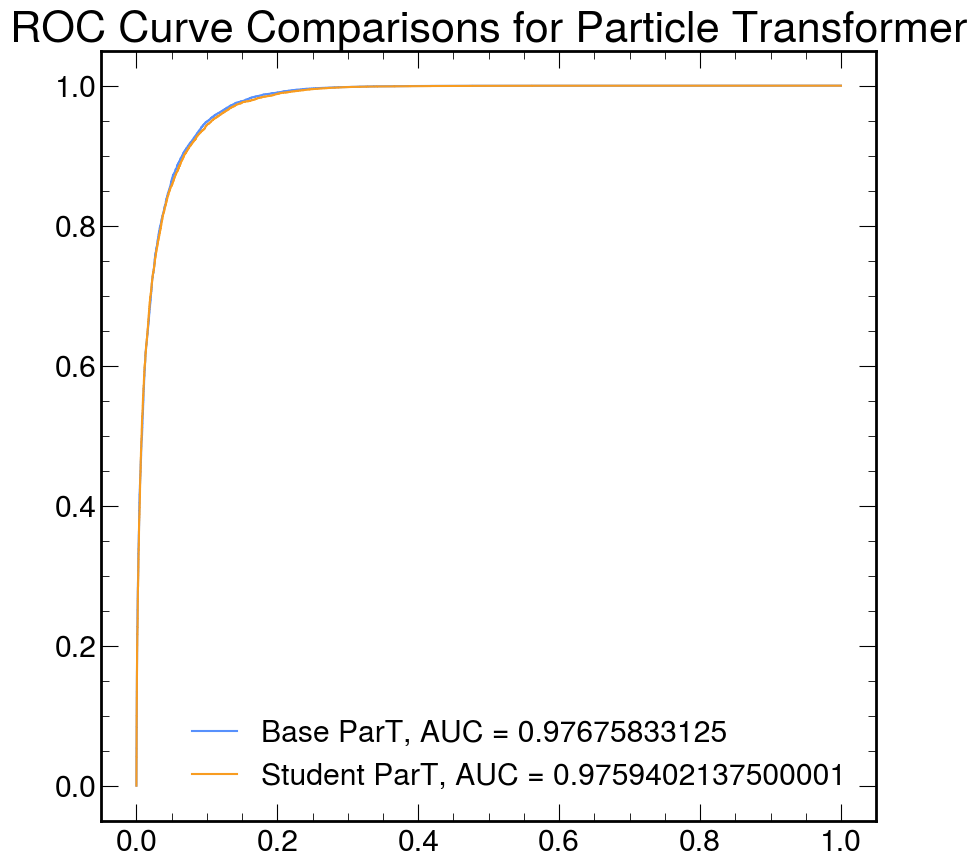

In [123]:
plt.plot(base_fpr, base_tpr, label = f'Base ParT, AUC = {base_auc}')
plt.plot(kd_fpr, kd_tpr, label = f'Student ParT, AUC = {kd_auc}')
plt.legend()
plt.title('ROC Curve Comparisons for Particle Transformer')
plt.show()

In [124]:
print('Base:')
base_bkg = metrics.bkg_rej(base_labels['_label_'], base_scores)
print('KD:')
kd_bkg = metrics.bkg_rej(kd_labels['_label_'], kd_scores)

diff = kd_bkg/base_bkg

print(f'{diff} Times Higher Background Rejection')

Base:
Background Rejection at 50.0% Signal Efficiency: 126.58227848101265
KD:
Background Rejection at 50.0% Signal Efficiency: 135.13513513513513
1.0675675675675675 Times Higher Background Rejection


NameError: name 'kd_logits' is not defined

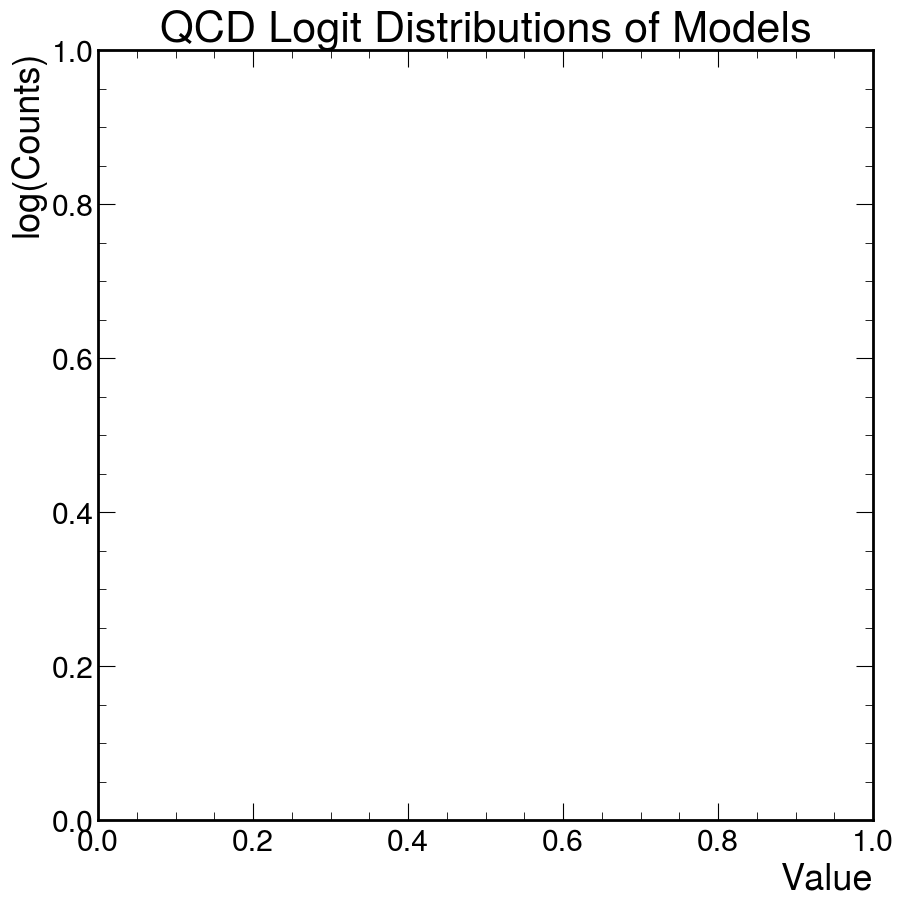

In [89]:
fig, axes = plt.subplots()

axes.set_title('QCD Logit Distributions of Models')
axes.set_xlabel('Value')
axes.set_ylabel('log(Counts)')
bins = 100

qcd_logits = kd_logits[:, 0]
axes.hist(qcd_logits, bins=bins, label=r'ParT Student, T=7, $\alpha$=1', alpha=0.8)

qcd_logits = base_logits[:, 0]
axes.hist(qcd_logits, bins=bins, label=r'ParT', alpha=0.8)

#axes.set_yscale('log')
axes.legend()

plt.show()

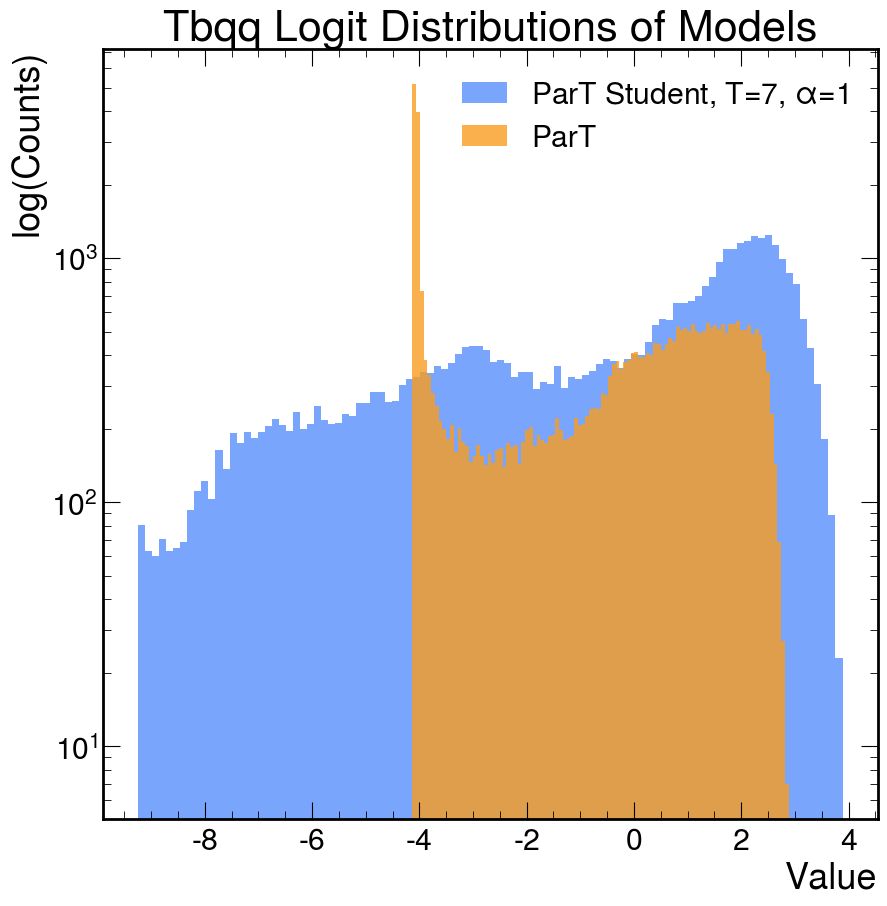

In [255]:
fig, axes = plt.subplots()

axes.set_title('Tbqq Logit Distributions of Models')
axes.set_xlabel('Value')
axes.set_ylabel('log(Counts)')
bins = 100
    
top_logits = kd_logits[:, 1]
axes.hist(top_logits, bins=bins, label=r'ParT Student, T=7, $\alpha$=1', alpha=0.8)

top_logits = base_logits[:, 1]
axes.hist(top_logits, bins=bins, label=r'ParT', alpha=0.8)

axes.set_yscale('log')
axes.legend()

plt.show()

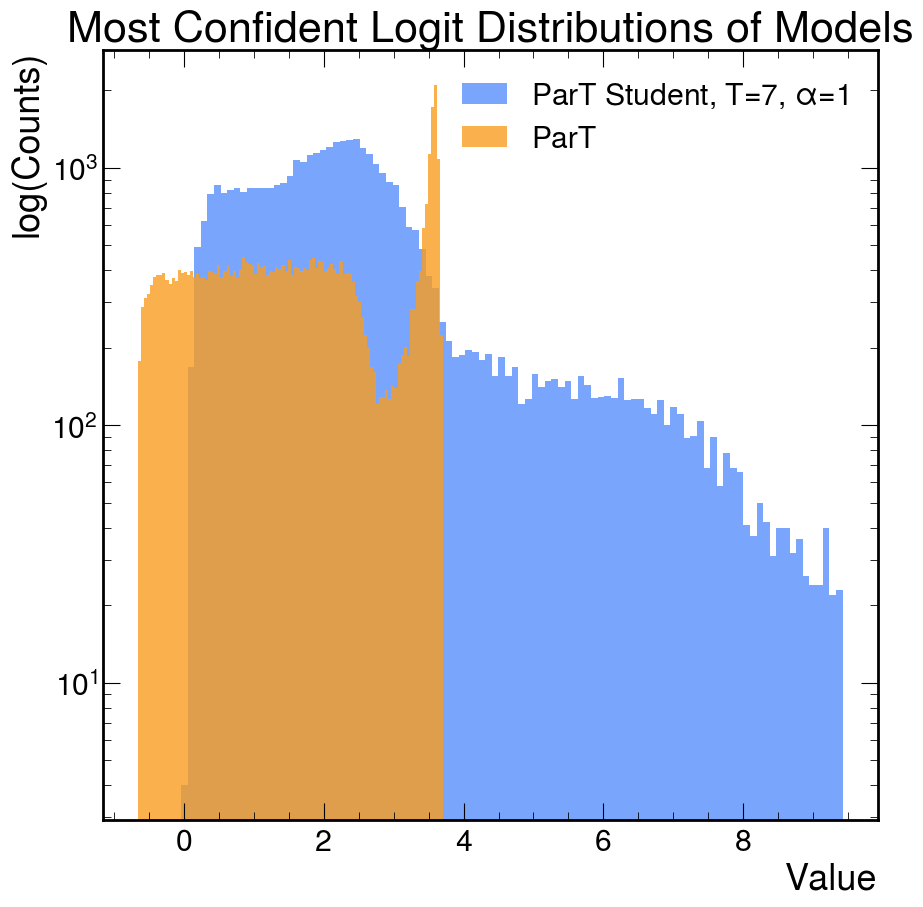

In [257]:
fig, axes = plt.subplots()

axes.set_title('Most Confident Logit Distributions of Models')
axes.set_xlabel('Value')
axes.set_ylabel('log(Counts)')
bins = 100
    
axes.hist(np.max(kd_logits, axis=1), bins=bins, label=r'ParT Student, T=7, $\alpha$=1', alpha=0.8)
axes.hist(np.max(base_logits, axis=1), bins=bins, label=r'ParT', alpha=0.8)
axes.set_yscale('log')
axes.legend()

plt.show()

In [27]:
import xgboost as xgb

model = xgb.XGBRegressor(
    max_depth = 16,
    n_estimators = 1000,
    learning_rate = 1e-03,
    eval_metric='rmse',
    device = 'cuda',
)

model.fit(df, np_logits)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [29]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = model.predict(df)
mse = mean_squared_error(np_logits, predictions)
r2score = r2_score(np_logits, predictions)

print(f'MSE: {mse}')
print(f'R2 Score: {r2score}')

MSE: 0.8003453016281128
R2 Score: 0.8265994787216187


In [30]:
gain = model.get_booster().get_score(importance_type='gain')

gain_df = pd.DataFrame({
    'feature': list(gain.keys()),
    'importance': list(gain.values())
}).sort_values(by='importance', ascending=False)

gain_df

,feature,importance
65,part_deltaR_p1,929.690613
64,part_deltaR_p0,171.764252
68,part_deltaR_p4,89.747185
66,part_deltaR_p2,79.465858
67,part_deltaR_p3,76.780075
...,...,...
164,part_isMuon_p4,0.196266
165,part_isMuon_p5,0.195261
172,part_isMuon_p12,0.097235
170,part_isMuon_p10,0.048649


In [31]:
top_features = gain_df['feature'].head(50).tolist()

In [32]:
x = df[top_features]
y = np_logits

In [33]:
x

,part_deltaR_p1,part_deltaR_p0,part_deltaR_p4,part_deltaR_p2,part_deltaR_p3,part_pt_log_p12,part_pt_log_p11,part_pt_log_p10,part_deltaR_p5,part_pt_log_p13,...,part_d0_p1,part_pt_log_p7,part_dz_p3,part_d0_p6,part_deltaR_p14,part_isNeutralHadron_p15,part_e_log_p7,part_logptrel_p3,part_logptrel_p6,part_logerel_p14
0,0.162854,0.184644,1.728007,0.232861,0.430764,0.544620,0.546878,0.559897,0.253113,0.536887,...,0.000000,0.594336,0.000000,-0.993782,-0.260069,0.0,0.510422,1.172804,0.751996,0.600124
1,0.596228,0.553762,0.776709,0.447682,0.632850,0.640800,0.669589,0.735163,0.614525,0.601134,...,0.000000,0.888104,0.997201,0.000000,-0.194194,0.0,0.873345,1.228863,1.083999,0.742496
2,-0.319383,-0.496593,-0.506183,-0.352316,-0.333827,0.905849,1.081769,1.126358,-0.139828,0.759033,...,0.000000,1.185417,-0.009694,0.000000,0.012697,0.0,1.002820,1.284260,0.898488,0.444101
3,0.252714,-0.187555,-0.529308,0.252441,-0.272209,0.813818,0.934964,0.946113,-0.260933,0.782700,...,-0.009288,1.353688,-0.785357,0.000000,0.474421,0.0,1.319293,1.320396,1.166821,0.319276
4,0.651059,0.101417,0.785451,0.627427,0.162873,0.724145,0.748885,0.785765,0.597181,0.678598,...,0.046976,0.912950,0.000000,0.000000,0.123710,0.0,1.241311,1.260841,1.033278,0.771759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.732164,-0.768479,-0.797401,-0.768108,-0.764769,-0.398776,-0.388567,-0.332453,-0.544295,-0.661280,...,0.000000,1.149627,-0.014222,-0.021216,-0.278907,0.0,0.980784,1.759432,1.087856,-0.759145
9996,-0.637194,-0.614560,-0.713984,-0.644512,-0.655320,0.104947,0.335882,0.377271,-0.639157,0.095754,...,-0.012327,0.975222,-0.012561,0.000000,1.913098,0.0,1.125942,1.577623,1.163591,0.130941
9997,-0.767361,-0.724348,-0.676934,-0.523128,-0.756938,0.233693,0.272819,0.468595,-0.769496,0.134042,...,-0.019223,0.914479,0.015877,-0.008842,-0.705334,0.0,1.312182,1.722548,1.047611,0.176478
9998,-0.763968,-0.748273,-0.701463,-0.721181,-0.706578,0.303642,0.304145,0.467344,-0.415951,0.236182,...,0.000000,1.170534,-0.015190,-0.016848,-0.664503,0.0,1.171893,1.775320,1.349325,0.115716


In [102]:
outputdir = workdir + '/outputs/pysr_outputs/sr_tests'

In [108]:
from pysr import jl

In [109]:
jl.seval("""
import Pkg
Pkg.add("Divergences")
""")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed RecipesBase ── v1.3.4
   Installed LaTeXStrings ─ v1.4.0
   Installed Distances ──── v0.10.12
   Installed Divergences ── v0.4.1
    Updating `~/anaconda3/envs/part_gp/julia_env/Project.toml`
  [7f07e4c8] + Divergences v0.4.1
    Updating `~/anaconda3/envs/part_gp/julia_env/Manifest.toml`
  [b4f34e82] + Distances v0.10.12
  [7f07e4c8] + Divergences v0.4.1
  [b964fa9f] + LaTeXStrings v1.4.0
  [3cdcf5f2] + RecipesBase v1.3.4
Precompiling packages...
   1081.3 ms  ✓ LaTeXStrings
   1969.9 ms  ✓ RecipesBase
   2347.1 ms  ✓ Distances
    479.2 ms  ✓ Distances → DistancesChainRulesCoreExt
    663.6 ms  ✓ Distances → DistancesSparseArraysExt
   1663.7 ms  ✓ Divergences
  6 dependencies successfully precompiled in 5 seconds. 162 already precompiled.


In [110]:
jl.seval("import Divergences")

In [112]:
kl_temp = 3
kl_alpha = 1

In [125]:
objective = '''
function logits_objective(tree, dataset::Dataset{T, L}, options)::L where {T, L}
    (prediction, completion) = eval_tree_array(tree, dataset.X, options)
    if !completion
        return L(Inf)
    end

    residuals = prediction .- dataset.y
    
    KL = Divergences.KullbackLeibler()
    divergence = KL(prediction/3, dataset.y/3)

    return (sum((residuals) .^ 2) / dataset.n) + 1 * divergence * (3*3)
end
'''

In [162]:
model = PySRRegressor(
    maxsize=55,
    niterations=10,
    populations=2,
    population_size = 27,
    ncycles_per_iteration = 100,
    weight_optimize=0.001,
    binary_operators=[
        "+", 
        "-", 
        "*", 
        "/", 
        "^",
        "distance(x, y) = (y-x)^2"
    ],
    unary_operators = [
        "sqrt", 
        "exp",
        "tanh",
    ],
    constraints = {
        '^': (-1, 1), 
        "min": (1, 1)
    },
    nested_constraints = {
        "exp": {"exp": 0, "^": 2, "tanh": 0}, 
        "*": {"exp": 1, "tanh": 1},
        "^": {"exp": 0, "tanh": 0},
        "tanh": {"tanh": 0, "exp": 0, "^": 1},
    },
    extra_sympy_mappings={
        "distance": lambda x, y: (y-x)**2,
    },
    output_directory = outputdir,
    parsimony = 0.005,
    batching=True,
    annealing=True,
    elementwise_loss = 'L2DistLoss()'
)

In [163]:
model.fit(df, np_logits)

/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/pysr/sr.py:1469: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final populations:
[ Info: Output 1:
[ Info: Output 2:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.743e+01  0.000e+00  y₀ = 0.15894
2           1.740e+01  1.730e-03  y₀ = tanh(part_dzerr_p10)
3           1.639e+01  5.986e-02  y₀ = part_deta_p7 - part_deltaR_p12
4           1.609e+01  1.834e-02  y₀ = exp(part_deta_p7 - part_e_log_p11)
5           1.387e+01  1.483e-01  y₀ = distance(part_deltaR_p3, 1.01) - 0.4781
6           1.387e+01  5.973e-05  y₀ = distance(0.83576, part_deltaR_p3) - exp(part_charge_...
                                       p7)
9           9.171e+00  1.379e-01  y₀ = distance(part_deltaR_p3, 2.1314) - (distance(part_lo...
                                       gerel_p6, -0.92559) + 2.2496)
───────────────────────────────────────────────────────────────────────────────────────────────────
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Sc

,model_selection,'best'
,binary_operators,"['+', '-', ...]"
,unary_operators,"['sqrt', 'exp', ...]"
,expression_spec,None
,niterations,10
,populations,2
,population_size,27
,max_evals,None
,maxsize,55
,maxdepth,None
,warmup_maxsize_by,None


In [107]:
print(model)

PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                        0.088697396   
	1         0.006349                            sqrt(part_isPhoton_p10)   
	2         0.359480                         part_deltaR_p2 * -3.993966   
	3         0.184933     (part_deltaR_p2 + part_logptrel_p14) * -3.6295   
	4   >>>>  0.187002       exp(part_deltaR_p2 * -2.9552934) - 4.1154366   
	5         0.078306  exp((part_deltaR_p2 * -2.1137636) - part_delta...   
	6         0.033703  (exp((part_deltaR_p2 * -2.1137636) - part_delt...   
	7         0.037688  exp((part_deltaR_p2 * -1.8626801) - part_delta...   
	8         0.010391  (exp((part_deltaR_p2 * -1.8626801) - part_delt...   
	9         0.000646  (((part_dz_p5 + exp(((-1.1169945 / part_pt_log...   
	10        0.000421  (((((part_isNeutralHadron_p3 / 1.8060491) + -2...   
	11        0.012466  exp((part_deltaR_p2 * -1.7276319) - part_delta...   
	12    

In [34]:
model.pytorch()

[_SingleSymPyModule(expression=part_deltaR_p1*(-2.3387632) + part_dz_p1),
 _SingleSymPyModule(expression=part_logptrel_p15 + part_logptrel_p15)]

In [17]:
import fastjet
import uproot
import awkward as ak
import vector
vector.register_awkward()

In [18]:
demo_set = '/home/alang/ppCodes/part_gp/datasets/JetClass/Pythia/train_100M/TTBar_006.root'

In [19]:
tree = uproot.open(demo_set + ':tree')

In [301]:
pt = np.hypot(tree['part_px'].array(), tree['part_py'].array())

In [302]:
pt

<Array [[46.4, 40.8, ..., 0.845, 0.699], ...] type='100000 * var * float32'>

In [ ]:
tree.show()

In [ ]:
np.hypot(tree['part_px'].array(), tree['part_py'].array())

In [ ]:
tree['part_px'].array()

In [36]:
p4 = vector.zip({'px': tree['part_px'].array(), 'py': tree['part_py'].array(), 'pz': tree['part_pz'].array(), 'E': tree['part_energy'].array()})

In [37]:
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.8)
cluster = fastjet.ClusterSequence(p4, jetdef)

In [40]:
ak.type(p4[0])

ArrayType(RecordType([NumpyType('float32'), NumpyType('float32'), NumpyType('float32'), NumpyType('float32')], ['x', 'y', 'z', 't'], parameters={'__record__': 'Momentum4D'}), 74, None)

In [ ]:
cluster.exclusive_jets_up_to(4)

In [23]:
subjets = cluster.exclusive_jets_up_to(4)

In [24]:
np.hypot(ak.sum(subjets.eta, axis = 1), ak.sum(subjets.phi, axis = 1))

<Array [12.8, 6.25, 5.67, 5.53, ..., 6.58, 10.8, 6.73] type='100000 * float64'>

In [28]:
yaml_config = workdir + '/data_config/JetClass/JetClass_kin.yaml'
network_path = workdir + '/models/networks/part_wrapper.py'

jc_paths = {
    'train': path_datasets+'/JetClass/Pythia/train_100M',
    'val': path_datasets+'/JetClass/Pythia/val_5M',
    'test': path_datasets+'/JetClass/Pythia/test_20M'
}

num_classes = 2
signal = '/TTBar_*.root'
background = '/ZJetsToNuNu_*.root'

datasets = {}

for name, path in jc_paths.items():

    if isinstance(signal, str):
        signal_files = glob.glob(path+signal)

    if isinstance(background, str):
        background_files = glob.glob(path+background)

    datasets[name] = signal_files + background_files

complexity = {
    'particle_attn': 2,
    'class_attn': 1
}

In [29]:
metadata = initialize_models(network_path, yaml_config, training=True)

In [30]:
args = Args(
    data_train = datasets['train'],
    data_val = datasets['val'],
    data_test = datasets['test'],
    data_config = yaml_config,
    num_epochs = 5,
    batch_size = 64,
    model_prefix = workdir + '/models/torch_saved/',
    file_fraction = 0.1,
    data_fraction = 0.1
)

In [31]:
train_loader, val_loader, data_config, train_input_names, train_label_names = train_load(args)

In [32]:
model = copy.deepcopy(metadata['model']).to(device)
loss_func = metadata['loss']

In [33]:
opt, scheduler = optim(args, model, device)

In [ ]:
tb = None

# training loop
best_valid_metric = np.inf if args.regression_mode else 0
grad_scaler = torch.amp.GradScaler("cuda")
for epoch in range(args.num_epochs):
    if args.load_epoch is not None:
        if epoch <= args.load_epoch:
            continue
    _logger.info('-' * 50)
    _logger.info('Epoch #%d training' % epoch)
    train_classification(model, loss_func, opt, scheduler, train_loader, device, epoch,
          steps_per_epoch=args.steps_per_epoch, grad_scaler=grad_scaler, tb_helper=tb)
    if args.model_prefix and (args.backend is None or local_rank == 0):
        dirname = os.path.dirname(args.model_prefix)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)
        state_dict = model.module.state_dict() if isinstance(
            model, (torch.nn.DataParallel, torch.nn.parallel.DistributedDataParallel)) else model.state_dict()
        torch.save(state_dict, args.model_prefix + '_epoch-%d_state.pt' % epoch)
        torch.save(opt.state_dict(), args.model_prefix + '_epoch-%d_optimizer.pt' % epoch)
    # if args.backend is not None and local_rank == 0:
    # TODO: save checkpoint
    #     save_checkpoint()

    _logger.info('Epoch #%d validating' % epoch)
    valid_metric = evaluate_classification(model, val_loader, device, epoch, loss_func=loss_func,
                            steps_per_epoch=args.steps_per_epoch_val, tb_helper=tb)
    is_best_epoch = (
        valid_metric < best_valid_metric) if args.regression_mode else(
        valid_metric > best_valid_metric)
    if is_best_epoch:
        best_valid_metric = valid_metric
        if args.model_prefix and (args.backend is None or local_rank == 0):
            shutil.copy2(args.model_prefix + '_epoch-%d_state.pt' %
                         epoch, args.model_prefix + '_best_epoch_state.pt')
            # torch.save(model, args.model_prefix + '_best_epoch_full.pt')
    _logger.info('Epoch #%d: Current validation metric: %.5f (best: %.5f)' %
                 (epoch, valid_metric, best_valid_metric), color='bold')

In [163]:
weights_path = workdir + '/models/torch_saved/_epoch-4_state.pt'

pred_metadata = initialize_models(network_path, yaml_config, training=False, model_path = weights_path)

In [164]:
pred_model = copy.deepcopy(pred_metadata['model']).to(device)

In [158]:
hook_manager = {
    'forward_hooks': {
        'logits': 'fc'
    },
    'pre_forward_hooks': {
        'inputs': 'trimmer'
    }
}

In [159]:
handles, outputs = HookHandler(pred_model, hook_manager).registration(safety_remove = True)


Removing all hooks within the model

Forward Hook Registered: logits

Forward Hook Registered: inputs


In [161]:
pred_args = Args(
    data_test = datasets['train'],
    data_config = yaml_config,
    batch_size = 32,
    file_fraction = 1,
    data_fraction = 0.001
)

test_loaders, data_config = test_load(pred_args)

In [ ]:
for name, get_test_loader in test_loaders.items():
    
    test_loader = get_test_loader()
    
    test_metric, scores, labels, observers = evaluate_classification(pred_model, test_loader, device, epoch=None, for_training=False)
    
    del test_loader

In [39]:
labels

{'_label_': array([8, 8, 8, ..., 0, 0, 0])}

In [40]:
observers.keys()

dict_keys(['jet_pt', 'jet_eta', 'jet_phi', 'jet_energy', 'jet_nparticles', 'jet_sdmass', 'jet_tau1', 'jet_tau2', 'jet_tau3', 'jet_tau4'])

In [41]:
scores

array([[3.6618221e-01, 9.9138006e-08, 8.5051774e-08, ..., 7.2337009e-08,
        6.3381714e-01, 8.1728146e-08],
       [1.6340796e-02, 4.2669663e-07, 3.6290990e-07, ..., 3.3490110e-07,
        9.8365641e-01, 3.8060898e-07],
       [3.6097053e-01, 8.5418939e-08, 7.7564316e-08, ..., 6.4595149e-08,
        6.3902885e-01, 6.8117245e-08],
       ...,
       [9.9977642e-01, 4.5639447e-07, 4.8988920e-07, ..., 4.0346794e-07,
        2.2044311e-04, 3.8627752e-07],
       [9.9606353e-01, 2.9235137e-08, 3.6397946e-08, ..., 2.7575567e-08,
        3.9364053e-03, 2.5109756e-08],
       [8.7035954e-01, 4.6466312e-08, 5.0026145e-08, ..., 3.8839907e-08,
        1.2964018e-01, 3.7041652e-08]], dtype=float32)

In [23]:
model = PySRRegressor.from_file(run_directory=workdir+'/outputs/pysr_outputs/sr_tests/20260117_100644_bfquQb')

Attempting to load model from /home/alang/ppCodes/part_gp/outputs/pysr_outputs/sr_tests/20260117_100644_bfquQb/checkpoint.pkl...


In [24]:
model

,model_selection,'best'
,binary_operators,"['+', '-', ...]"
,unary_operators,"['sqrt', 'tanh', ...]"
,expression_spec,None
,niterations,1600
,populations,48
,population_size,27
,max_evals,None
,maxsize,60
,maxdepth,None
,warmup_maxsize_by,None


In [25]:
print(model)

PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                        -0.33768696   
	1         0.119404                                       sin(lnz_150)   
	2         0.209018                           part_deltaR_p2 * lnz_150   
	3         0.075651       (part_pt_log_p15 + part_deltaR_p1) * lnz_151   
	4         0.028419    lnz_150 * sin(part_deltaR_p2 + part_pt_log_p15)   
	5         0.062692  ((part_pt_log_p15 + part_deltaR_p1) * lnz_131)...   
	6         0.038537  (sin(part_pt_log_p15 + part_deltaR_p1) * lnz_1...   
	7         0.058077  ((part_deltaR_p1 + part_deltaR_p2) * (lnz_142 ...   
	8         0.008056  ((lnz_150 * sin(part_deltaR_p1 + part_pt_log_p...   
	9   >>>>  0.074309  ((part_deltaR_p0 + part_deltaR_p1) * (part_del...   
	10        0.001600  ((sin(part_deltaR_p8) + (lnz_152 + part_deltaR...   
	11        0.017569  ((part_deltaR_p1 + part_deltaR_p0) * (lnz_151 ...   
	12    

In [176]:
mapping = {
    'distance': lambda x, y: (y-x)**2
}

new_params = {
    'extra_torch_mappings': {
    'distance': lambda x, y: (y-x)**2
}
}

In [177]:
model.set_params(**new_params)

,model_selection,'best'
,binary_operators,"['+', '-', ...]"
,unary_operators,"['sqrt', 'exp', ...]"
,expression_spec,None
,niterations,800
,populations,48
,population_size,27
,max_evals,None
,maxsize,55
,maxdepth,None
,warmup_maxsize_by,None


In [ ]:
model.latex([20, 19])

In [27]:
modules = model.pytorch([29, 29])

In [44]:
sympy_equations = model.sympy([29, 29])

In [46]:
sympy_equations[1]

part_pt_log_p13 + part_pt_log_p4 - 0.041131288*(-lndelta_112 + (lnkt_1413 + lnm2_109 + (1.090197 - part_deltaR_p1)*(part_logptrel_p0**lnkt_1513 - (6.850784 - lnkt_128) + (part_deltaR_p4 - (0.87042165 - part_deltaR_p3))*4.3909082))*(lnz_151 + part_deltaR_p5 + part_deltaR_p7))

In [28]:
class CloudFlattener(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        _, self.n_features, self.n_particles = input_dim
    def forward(self, x):
        x = torch.reshape(x, (x.size(dim=0), self.n_features * self.n_particles))
        return x

class TestNN(torch.nn.Module):
    def __init__(self, input_dim, module_list):
        super().__init__()

        self.input_dim = input_dim
        self.cloud_flattener = CloudFlattener(input_dim)
        self.qcd_pred = module_list[0]
        self.top_pred = module_list[1]

    def forward(self, x):
        x = self.cloud_flattener(x)
        qcd_logits = self.qcd_pred(x)
        top_logits = self.top_pred(x)

        return [qcd_logits, top_logits]

In [29]:
feature_dim = pred_metadata['info']['input_shapes']['pf_features']

In [30]:
test_model = TestNN((1, 656, 1), modules).to(device)

In [31]:
with torch.no_grad():
    test_model.eval()
    test_preds=test_model(torch.from_numpy(df.to_numpy()).to(device))

In [32]:
preds = torch.cat([tensor.unsqueeze(1) for tensor in test_preds], dim=1).detach().cpu().numpy()

In [33]:
from sklearn.metrics import log_loss, roc_auc_score
from scipy.special import softmax

student_cce = log_loss(labels['_label_'][nonpadded_mask], softmax(preds, axis=1))
student_auc = roc_auc_score(labels['_label_'][nonpadded_mask], softmax(preds, axis=1)[:,1])

print(f'Student CCE: {student_cce}')
print(f'Student AUC: {student_auc}')

teacher_cce = log_loss(labels['_label_'][nonpadded_mask], scores[nonpadded_mask])
teacher_auc = roc_auc_score(labels['_label_'][nonpadded_mask], scores[nonpadded_mask][:,1])

print(f'ParT CCE: {teacher_cce}')
print(f'ParT AUC: {teacher_auc}')

Student CCE: 0.35457913986367284
Student AUC: 0.9146657814660141
ParT CCE: 0.2006422240084678
ParT AUC: 0.973670961277178


In [35]:
cm = metrics.confusion_matrices(labels['_label_'][nonpadded_mask], softmax(preds, axis=1))

In [34]:
metrics.bkg_rej(labels['_label_'][nonpadded_mask], softmax(preds, axis=1), eff = 0.5)

Background Rejection at 50.0% Signal Efficiency: 14.33751962323391


14.33751962323391

In [36]:
metrics.bkg_rej(labels['_label_'][nonpadded_mask], scores[nonpadded_mask], eff = 0.5)

Background Rejection at 50.0% Signal Efficiency: 123.4189189189189


123.4189189189189

In [ ]:
bkg_rejs = []

for i in range(1, 35):
    modules = model.pytorch([i, 29])
    test_model = TestNN((1, 656, 1), modules).to(device)
    with torch.no_grad():
        test_model.eval()
        test_preds=test_model(torch.from_numpy(df.to_numpy()).to(device))
        preds = torch.cat([tensor.unsqueeze(1) for tensor in test_preds], dim=1).detach().cpu().numpy()
    bkg_rej = metrics.bkg_rej(labels['_label_'][nonpadded_mask], softmax(preds, axis=1), eff = 0.5)
    bkg_rejs.append(bkg_rej)

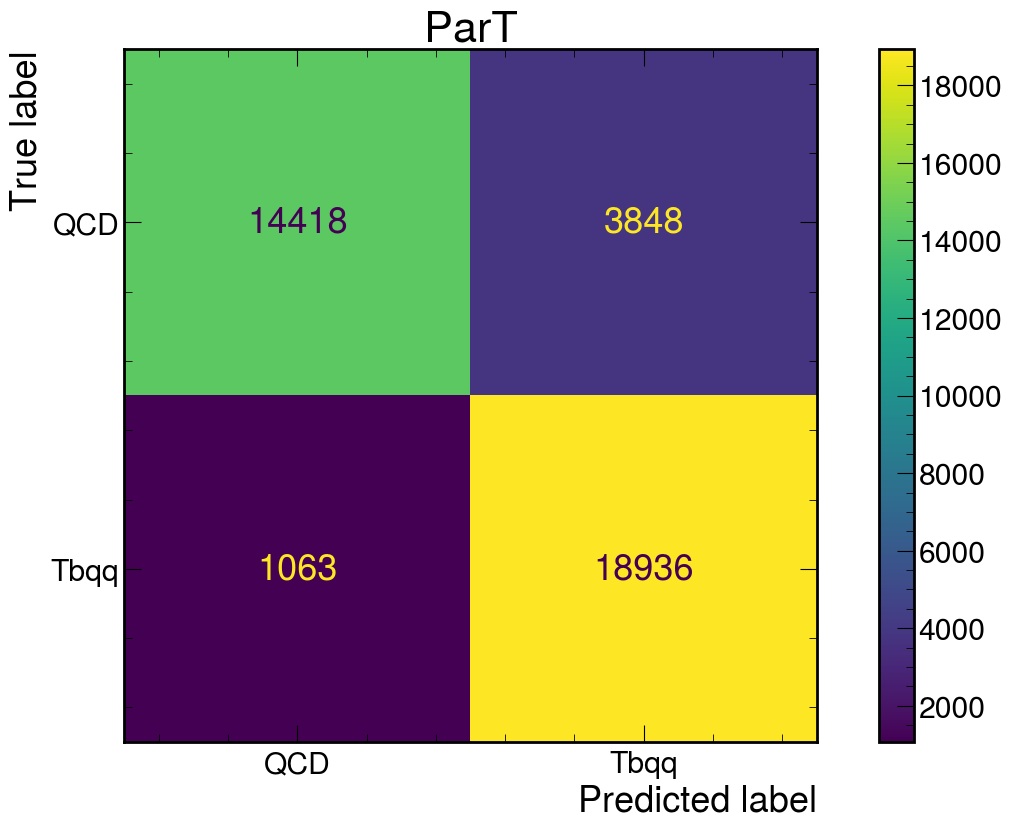

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(16, 9))
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['QCD', 'Tbqq']).plot(ax=ax)
disp_1.ax_.set_title('ParT')
plt.show()

In [64]:
preds

array([[-1.4693253,  0.7393245],
       [-0.8610616,  1.1149802],
       [-1.3007138,  1.3843702],
       ...,
       [ 3.87014  , -3.2486987],
       [ 5.9836836, -4.3279085],
       [ 4.1328506, -1.4963664]], dtype=float32)

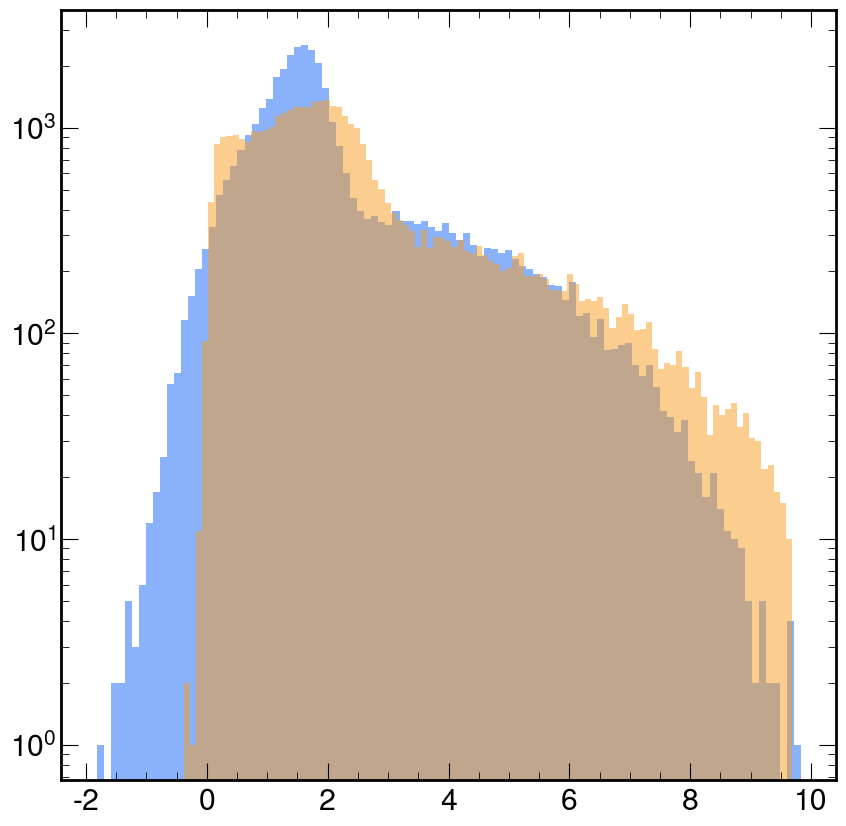

In [41]:
plt.hist(np.max(preds, axis=1), bins=100, alpha=0.7)
plt.hist(np.max(np_logits, axis=1), bins=100, alpha=0.5)
plt.yscale('log')
plt.show()

In [86]:
pred_args = Args(
    data_test = datasets['test'],
    data_config = yaml_config,
    batch_size = 32,
    file_fraction = 1,
    data_fraction = 0.1
)

hook_manager = {
    'forward_hooks': {
        'logits': 'fc'
    },
    'pre_forward_hooks': {
        'inputs': 'trimmer'
    }
}

handles, new_outputs = HookHandler(pred_model, hook_manager).registration(safety_remove = True)

test_test_loaders, test_data_config = test_load(pred_args)

for name, get_test_loader in test_test_loaders.items():
    
    test_test_loader = get_test_loader()
    
    new_test_metric, new_scores, new_labels, new_observers = evaluate_classification(pred_model, test_test_loader, device, epoch=None, for_training=False)
    
    del test_test_loader


Removing all hooks within the model

Forward Hook Registered: logits

Forward Hook Registered: inputs


0it [00:00, ?it/s]

=== Restarting DataIter test_, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
12500it [08:02, 25.89it/s, Loss=0.00000, AvgLoss=0.00000, Acc=0.96875, AvgAcc=0.92349]
y should be a 1d array, got an array of shape (400000, 2) instead.


In [87]:
new_inputs = new_outputs['pre_forward_hooks']['inputs']

In [88]:
new_concat_inputs = []

for v in range(3):
    if new_inputs[0][v] is None:
        continue
    
    new_concat_inputs.append(
        torch.cat(
            [new_inputs[i][v].cpu() for i in range(len(new_inputs))],
            dim=0
        ).numpy()
    )

new_primary_features = new_concat_inputs[0].reshape(400000, 7 * 16)
new_primary_features.shape

new_feature_names = test_data_config.input_dicts['pf_features']

new_columns = []

for feature in new_feature_names:
    for particle in range(16):
        new_columns.append(f"{feature}_p{particle}")

new_df = pd.DataFrame(new_primary_features, columns=new_columns)

In [369]:
import time
start = time.time()

with torch.no_grad():
    test_model.eval()
    test_preds=test_model(torch.from_numpy(new_df.to_numpy()).to(device))

end = time.time()

elapsed = end-start

print(f'Elapsed Time: {elapsed}')

Elapsed Time: 1.9317317008972168


In [370]:
new_preds = torch.cat([tensor.unsqueeze(1) for tensor in test_preds], dim=1).detach().cpu().numpy()

In [371]:
from sklearn.metrics import log_loss, roc_auc_score
from scipy.special import softmax

student_probs = softmax(new_preds, axis=1)
teacher_probs = new_scores

In [372]:
total = len(new_labels['_label_'])

label_predictions = np.round(student_probs[:, 1])
avg_accuracy = np.mean(label_predictions == new_labels['_label_'])

print(f'Student Avg Accuracy: {avg_accuracy}')

Student Avg Accuracy: 0.8662925


In [373]:
student_cce = log_loss(new_labels['_label_'], student_probs)
student_auc = roc_auc_score(new_labels['_label_'], student_probs[:, 1])

print(f'Student CCE: {student_cce}')
print(f'Student AUC: {student_auc}')

teacher_cce = log_loss(new_labels['_label_'], teacher_probs)
teacher_auc = roc_auc_score(new_labels['_label_'], teacher_probs[:,1])

print(f'ParT CCE: {teacher_cce}')
print(f'ParT AUC: {teacher_auc}')

Student CCE: 0.38768735825094774
Student AUC: 0.9167947183
ParT CCE: 0.370557935388743
ParT AUC: 0.9892231908125


In [68]:
from sklearn.metrics import roc_curve

fpr_student, tpr_student, thresholds_student = roc_curve(new_labels['_label_'], student_probs[:, 1])
fpr_teacher, tpr_teacher, thresholds_teacher = roc_curve(new_labels['_label_'], teacher_probs[:, 1])

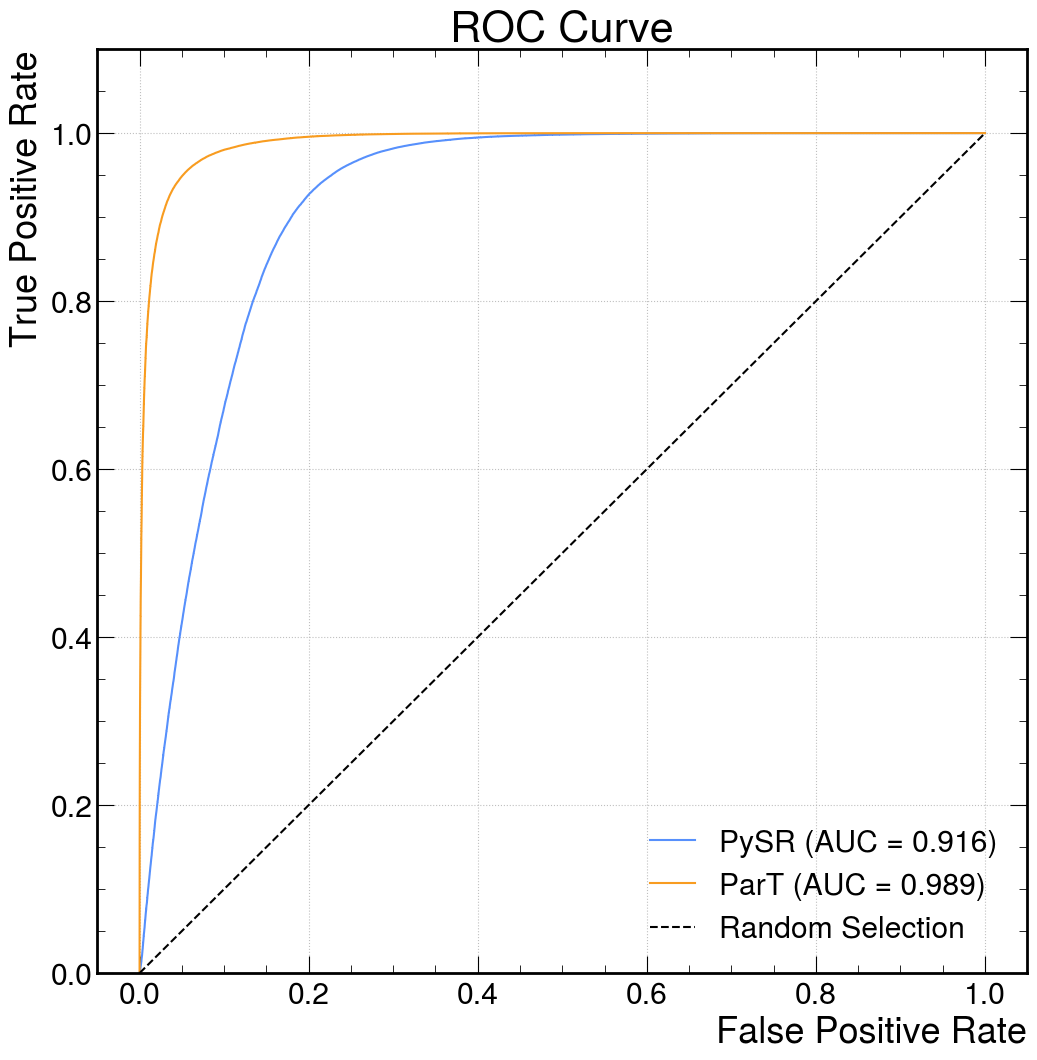

In [294]:
import mplhep as mh

plt.style.use(mh.style.CMS)

plt.figure(figsize=(12,12))
plt.plot(fpr_student, tpr_student, label=f'PySR (AUC = {student_auc:.3f})')
plt.plot(fpr_teacher, tpr_teacher, label=f'ParT (AUC = {teacher_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random Selection')

plt.ylim(0, 1.1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

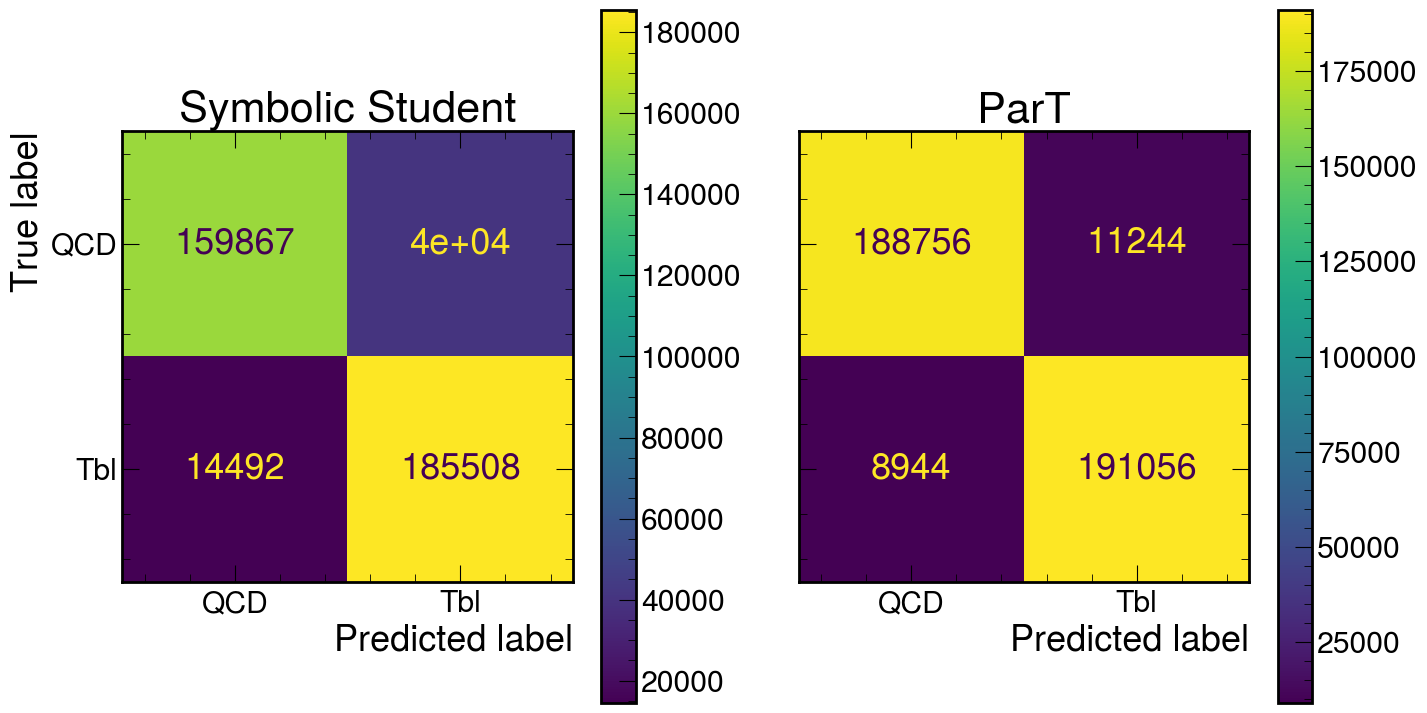

In [84]:
cm_student = confusion_matrix(y_true=new_labels['_label_'], y_pred = np.round(student_probs[:, 1]))
cm_part = confusion_matrix(y_true=new_labels['_label_'], y_pred = np.round(teacher_probs[:, 1]))


fig, ax = plt.subplots(1, 2, figsize=(16, 9))
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_student, display_labels=['QCD', 'Tbl']).plot(ax=ax[0])
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_part, display_labels=['QCD', 'Tbl']).plot(ax=ax[1])
disp_1.ax_.set_title('Symbolic Student')
disp_2.ax_.set_title('ParT')
disp_2.ax_.set_ylabel('')
disp_2.ax_.tick_params(axis='y', labelleft=False)

plt.show()

In [91]:
f1_student = f1_score(new_labels['_label_'], np.round(student_probs[:, 1]))
f1_teacher = f1_score(new_labels['_label_'], np.round(teacher_probs[:, 1]))

print(f'F1 Score for Symbolic Student: {f1_student}')
print(f'F1 Score for ParT: {f1_teacher}')

F1 Score for Symbolic Student: 0.8716641488954306
F1 Score for ParT: 0.9498185433755904


In [44]:
def flops(model, model_info, model_name, device='cpu'):
    """
    Count FLOPs and params.
    :param args:
    :param model:
    :param model_info:
    :return:
    """
    from weaver.utils.flops_counter import get_model_complexity_info
    import copy

    model = copy.deepcopy(model).to(device)
    model.eval()

    inputs = tuple(
        torch.ones(model_info['input_shapes'][k], dtype=torch.float32, device=device) for k in model_info['input_names'])

    macs, params = get_model_complexity_info(model, inputs, as_strings=True, print_per_layer_stat=True, verbose=True)
    print(f'{model_name} Computational complexity: {macs}')
    print(f'{model_name} Number of Parameters: {macs}')

In [34]:
demo_info = {
    'input_names': ['features'],
    'input_shapes': {'features': (1, 17, 16)}
}

In [85]:
flops(pred_model, pred_metadata['info'], 'ParT', device=device)

/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


ParT Computational complexity: 10.61 MMac
ParT Number of Parameters: 744.64 k


/tmp/ipykernel_2345/192088732.py:2: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr_student, 1/fpr_student, label=f'PySR')
/tmp/ipykernel_2345/192088732.py:3: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr_teacher, 1/fpr_teacher, label=f'ParT')


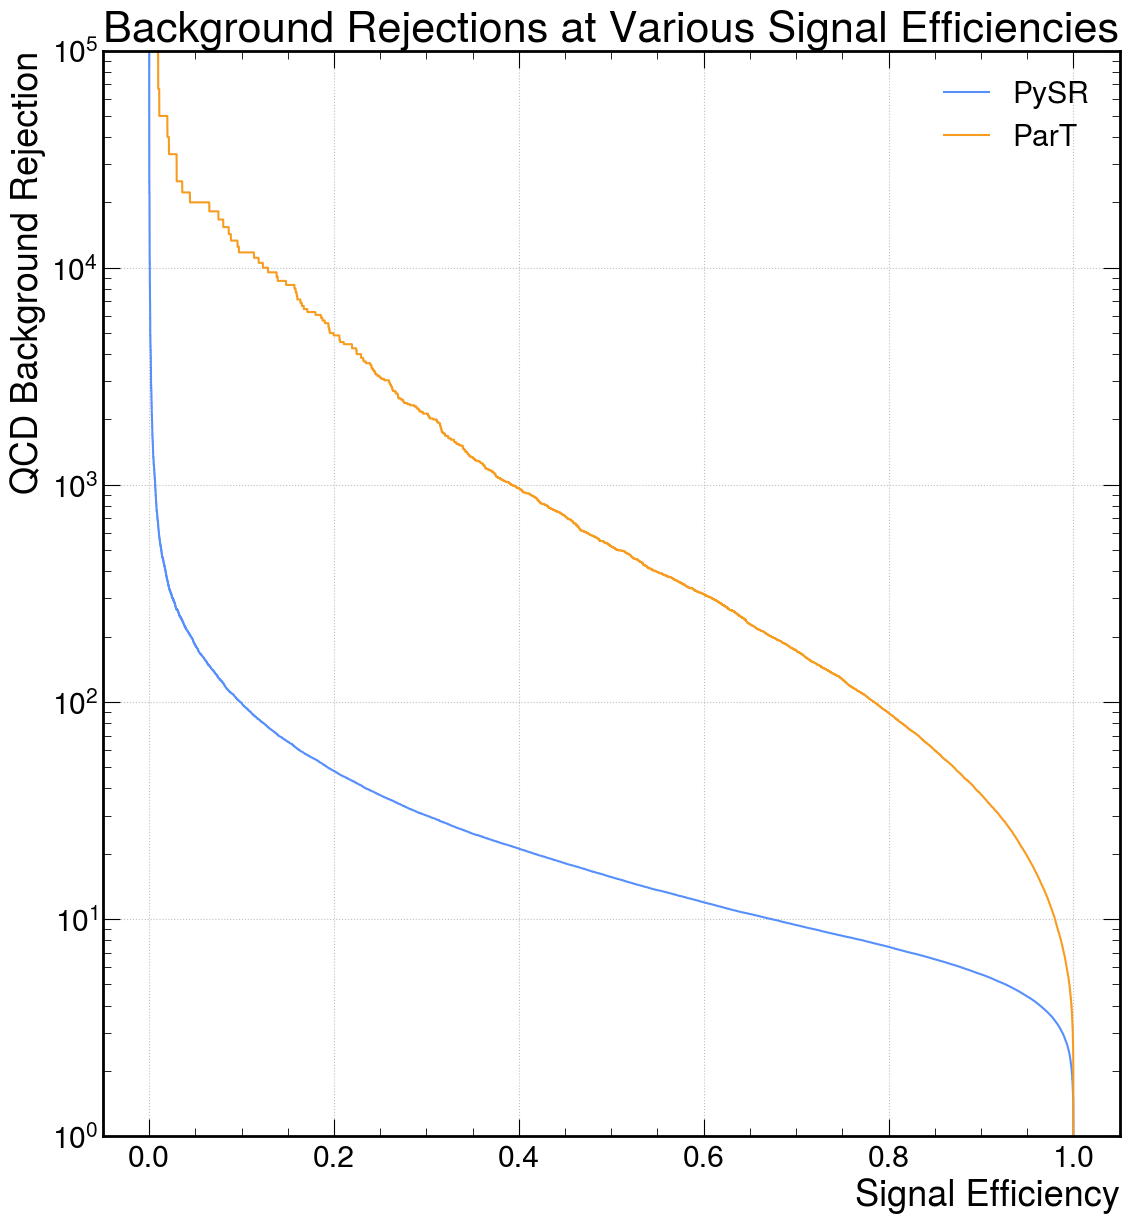

In [374]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(tpr_student, 1/fpr_student, label=f'PySR')
ax.plot(tpr_teacher, 1/fpr_teacher, label=f'ParT')

fig.tight_layout()

ax.set_xlabel('Signal Efficiency')
ax.set_ylabel('QCD Background Rejection')
ax.set_title('Background Rejections at Various Signal Efficiencies')
ax.set_yscale('log')
ax.set_ylim(bottom=1, top=1e5)
plt.legend()
ax.grid(True)
plt.show()

In [136]:
modules

[_SingleSymPyModule(expression=1.10135300114838*(-part_deltaR_p1 + cos(part_deltaR_p2 + part_pt_log_p12*sqrt(part_deltaR_p13 + exp(part_deltaR_p3) + exp(part_deltaR_p4)) + sqrt(part_deltaR_p9 + exp(part_deltaR_p5) + exp(sin(part_deltaR_p6)))))*exp(-part_deltaR_p1) - 1.10135300114838*sin(part_logptrel_p11) + 0.0711332294610606),
 _SingleSymPyModule(expression=part_deltaR_p0/(exp(part_deltaR_p5)*exp(part_deltaR_p7)) + part_deltaR_p2 + part_deltaR_p3 + part_pt_log_p6 + sin(part_deltaR_p0 + part_deltaR_p2 + part_deltaR_p3/exp(part_deltaR_p11) + part_pt_log_p11 + 1.3687044)*1.3149766)]

In [268]:
import time

warmup_size = 10
iterations = 100
sizes = [100, 1000, 5000, 10000, 25000, 50000, 100000, 200000, 300000, len(new_df)]
complexity_device = 'cpu'
complexity_model = copy.deepcopy(test_model.to(complexity_device))
mean_computation_times = []
complexity_model.eval()

if complexity_device == 'cpu':
    torch.set_num_threads(1)

# Warmup

warmup_set = torch.from_numpy(new_df.head(warmup_size).to_numpy()).to(complexity_device)
torch.cuda.synchronize()
for i in range(warmup_size):
    with torch.inference_mode():
        complexity_model(warmup_set)

with torch.inference_mode():
    for size in sizes:
        test_input = torch.from_numpy(new_df.head(size).to_numpy()).to(complexity_device)
        torch.cuda.synchronize()
        temp_array = []
        for i in range(iterations):
            start = time.time()
            complexity_model(test_input)
            torch.cuda.synchronize()
            
            end = time.time()
            
            temp_array.append(end-start)
        ms_mean_time = np.mean(temp_array)*1000
        mean_computation_times.append(ms_mean_time)
        print(f'Mean Computation Time (ms) at N={size}: {ms_mean_time}')

Mean Computation Time (ms) at N=100: 1.0820293426513672
Mean Computation Time (ms) at N=1000: 1.0335159301757812
Mean Computation Time (ms) at N=5000: 1.2972617149353027
Mean Computation Time (ms) at N=10000: 1.5574908256530762
Mean Computation Time (ms) at N=25000: 2.5652122497558594
Mean Computation Time (ms) at N=50000: 4.6872782707214355
Mean Computation Time (ms) at N=100000: 8.851723670959473
Mean Computation Time (ms) at N=200000: 19.79755163192749
Mean Computation Time (ms) at N=300000: 32.628421783447266
Mean Computation Time (ms) at N=400000: 46.11508846282959


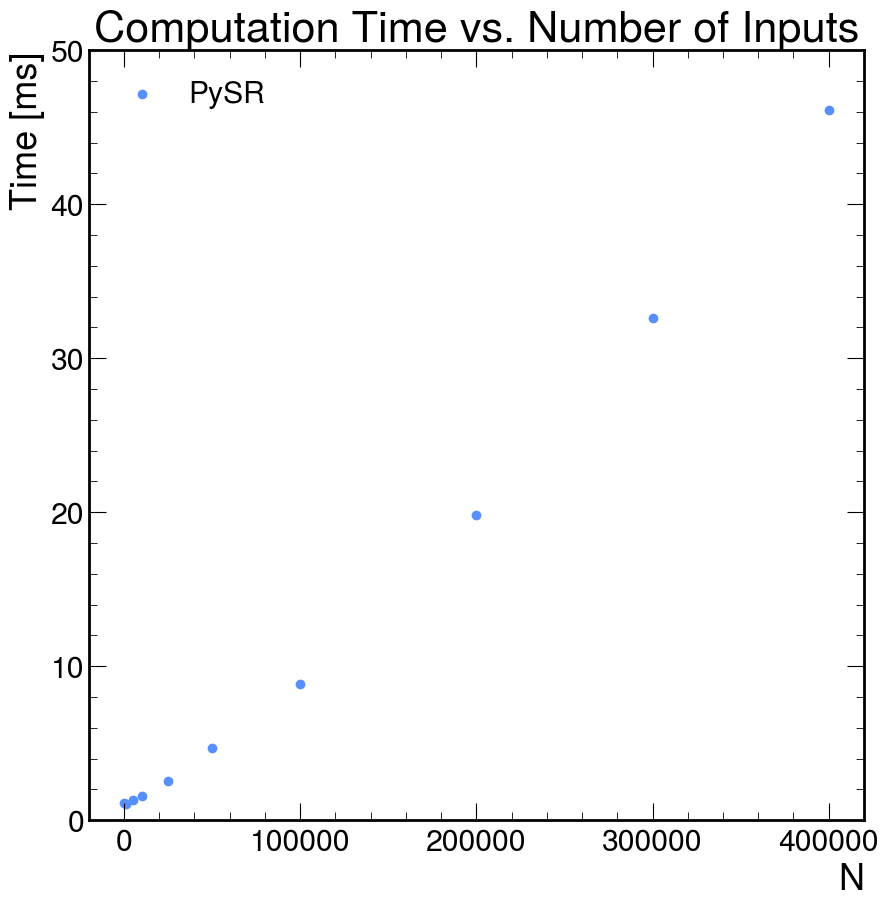

In [313]:
fig, ax = plt.subplots()

ax.scatter(sizes, mean_computation_times, label = 'PySR')
ax.set_title('Computation Time vs. Number of Inputs')
ax.set_ylabel('Time [ms]')
ax.set_xlabel('N')
ax.set_ylim(0, 50)
plt.legend()
plt.show()

In [350]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

student_qcd_logits = new_preds[:, 0]
teacher_qcd_logits = new_scores[:, 0]
student_top_logits = new_preds[:, 1]
teacher_top_logits = new_scores[:, 1]

In [345]:
res_qcd = spearmanr(student_qcd_logits, teacher_qcd_logits)
res_top = spearmanr(student_top_logits, teacher_top_logits)

print(f'For the QCD class, rho is {res_qcd.statistic} and the p-value is {res_qcd.pvalue}')
print(f'For the Top class, rho is {res_top.statistic} and the p-value is {res_top.pvalue}')

For the QCD class, rho is 0.8127142797285003 and the p-value is 0.0
For the Top class, rho is 0.7913301953914413 and the p-value is 0.0


In [351]:
r2_qcd = r2_score(teacher_qcd_logits, student_qcd_logits)
r2_top = r2_score(teacher_top_logits, student_top_logits)

print(f'R2 for QCD: {r2_qcd}')
print(f'R2 for Top: {r2_top}')

R2 for QCD: -14.724759101867676
R2 for Top: -27.284191131591797


In [363]:
from sklearn.metrics import mean_squared_error

mean_squared_error(teacher_qcd_logits, student_qcd_logits)

3.349088668823242

In [364]:
mean_squared_error(teacher_top_logits, student_top_logits)

6.024021148681641

In [25]:
def pelican_initialize(network_path, config_path, training = True, model_path = None) -> dict:

    models = {}
    
    network_module = import_module(network_path, name='_network_module')
    data_config = SimpleIterDataset({}, config_path, for_training=training).config
    model, model_info = network_module.get_model(data_config,
                                                 dataset='',
                                                 method='spurions',
                                                 stabilizer='so2',
                                                 average_nobj=16,
                                                 scale=0.1,
                                                 num_channels_scalar=10,
                                                 num_channels_m=[[60],]*5,
                                                 num_channels_2to2=[35,]*5,
                                                 num_channels_out=[60],
                                                 num_channels_m_out=[60, 35]
                                                )

    if model_path is not None:
        wts = torch.load(model_path, map_location = 'cpu', weights_only = True)
        model.load_state_dict(wts)
    
    model_metadata = {
        'model': model,
        'info': model_info,
        'loss': network_module.get_loss(data_config)
    }

    return model_metadata

In [26]:
pelican_network = workdir + '/models/networks/pelican_wrapper.py'

teacher_metadata = pelican_initialize(pelican_network, yaml_config, training=True)

In [27]:
teacher = copy.deepcopy(teacher_metadata['model']).to(device)
loss_func = teacher_metadata['loss']

In [28]:
args = Args(
    data_train = datasets['train'],
    data_val = datasets['val'],
    data_test = datasets['test'],
    data_config = yaml_config,
    num_epochs = 5,
    batch_size = 64,
    model_prefix = workdir + '/models/torch_saved/PELICAN',
    file_fraction = 1,
    data_fraction = 0.1,
    start_lr=1e-03,
    final_lr=1e-06,
    lr_scheduler='cos',
    optimizer='ranger',
)

In [29]:
train_loader, val_loader, data_config, train_input_names, train_label_names = train_load(args)

In [30]:
# optimizer & learning rate
opt, scheduler = optim(args, teacher, device)

In [31]:
training_handler = {}

In [ ]:
tb = None

# training loop
best_valid_metric = np.inf if args.regression_mode else 0
grad_scaler = torch.amp.GradScaler("cuda")

training_handler['PELICAN'] = {
'Avg Accuracy': [],
'ROC AUC': [],
'CCE Losses': []
}

for epoch in range(args.num_epochs):
    if args.load_epoch is not None:
        if epoch <= args.load_epoch:
            continue
    _logger.info('-' * 50)
    _logger.info('Epoch #%d training' % epoch)
    train_classification(teacher, loss_func, opt, scheduler, train_loader, device, epoch,
          steps_per_epoch=args.steps_per_epoch, grad_scaler=grad_scaler, tb_helper=tb)
    if args.model_prefix and (args.backend is None or local_rank == 0):
        dirname = os.path.dirname(args.model_prefix)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)
        state_dict = teacher.module.state_dict() if isinstance(
            teacher, (torch.nn.DataParallel, torch.nn.parallel.DistributedDataParallel)) else teacher.state_dict()
        torch.save(state_dict, args.model_prefix + '_epoch-%d_state.pt' % epoch)
        torch.save(opt.state_dict(), args.model_prefix + '_epoch-%d_optimizer.pt' % epoch)
    # if args.backend is not None and local_rank == 0:
    # TODO: save checkpoint
    #     save_checkpoint()

        
    _logger.info('Epoch #%d validating' % epoch)
    valid_metric, valid_scores, valid_labels, valid_observers = evaluate_classification(teacher, val_loader, device, epoch, for_training=False, loss_func=loss_func,
                            steps_per_epoch=args.steps_per_epoch_val, tb_helper=tb)
    
    training_handler['PELICAN']['Avg Accuracy'].append(valid_metric)
    training_handler['PELICAN']['ROC AUC'].append(roc_auc_score(valid_labels['_label_'], valid_scores[:,1], labels=[0,1]))
    training_handler['PELICAN']['CCE Losses'].append(log_loss(valid_labels['_label_'], valid_scores, labels=[0, 1]))

    is_best_epoch = (
        valid_metric < best_valid_metric) if args.regression_mode else(
        valid_metric > best_valid_metric)
    if is_best_epoch:
        best_valid_metric = valid_metric
        if args.model_prefix and (args.backend is None or local_rank == 0):
            shutil.copy2(args.model_prefix + '_epoch-%d_state.pt' %
                         epoch, args.model_prefix + '_best_epoch_state.pt')
            # torch.save(model, args.model_prefix + '_best_epoch_full.pt')
    _logger.info('Epoch #%d: Current validation metric: %.5f (best: %.5f)' %
                 (epoch, valid_metric, best_valid_metric), color='bold')

In [33]:
teacher_path = workdir + '/models/torch_saved/PELICAN_epoch-4_state.pt'
pelican_network = workdir + '/models/networks/pelican_wrapper.py'

In [34]:
teacher_metadata = pelican_initialize(pelican_network, yaml_config, training=False, model_path = teacher_path)

teacher_model = copy.deepcopy(teacher_metadata['model']).to(device)

In [39]:
pred_args = Args(
    data_test = datasets['test'],
    data_config = yaml_config,
    batch_size = 32,
    file_fraction = 1,
    data_fraction = 0.1
)

hook_manager = {
    'forward_hooks': {
        'logits': 'mlp_out'
    },
    'pre_forward_hooks': {}
}

handles, new_outputs = HookHandler(teacher_model, hook_manager).registration(safety_remove = True)

test_loaders, data_config = test_load(pred_args)

for name, get_test_loader in test_loaders.items():
    
    test_loader = get_test_loader()
    
    test_metric, scores, labels, observers = evaluate_classification(teacher_model, test_loader, device, epoch=None, for_training=False)
    
    del test_loader


Removing all hooks within the model

Forward Hook Registered: logits


0it [00:00, ?it/s]

=== Restarting DataIter test_, seed=None ===


12500it [20:17, 10.27it/s, Loss=0.00000, AvgLoss=0.00000, Acc=0.96875, AvgAcc=0.94437]
ERROR:weaver:y should be a 1d array, got an array of shape (400000, 2) instead.


In [40]:
concat_logits = torch.cat(new_outputs['forward_hooks']['logits'])

In [41]:
np_logits = concat_logits.cpu().numpy()

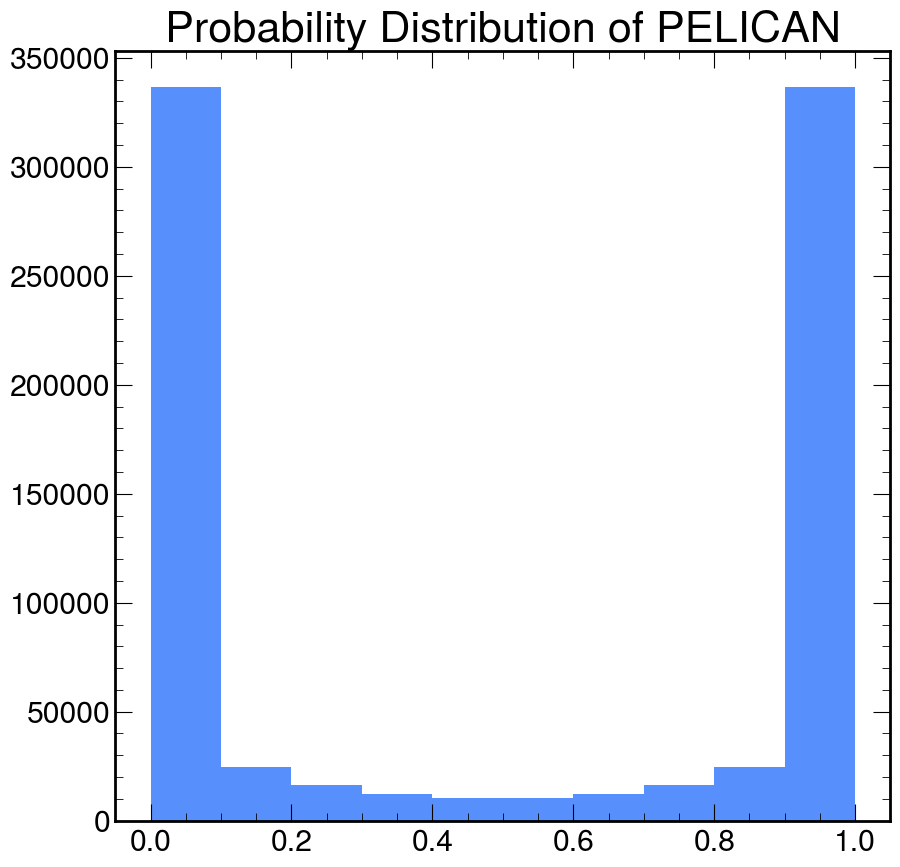

In [42]:
plt.hist(scores.flatten())
plt.title('Probability Distribution of PELICAN')
plt.show()

In [43]:
teacher_cce = log_loss(labels['_label_'], scores)
teacher_auc = roc_auc_score(labels['_label_'], scores[:,1])

print(f'PELICAN CCE: {teacher_cce}')
print(f'PELICAN AUC: {teacher_auc}')

PELICAN CCE: 0.13879704042456065
PELICAN AUC: 0.98751054865


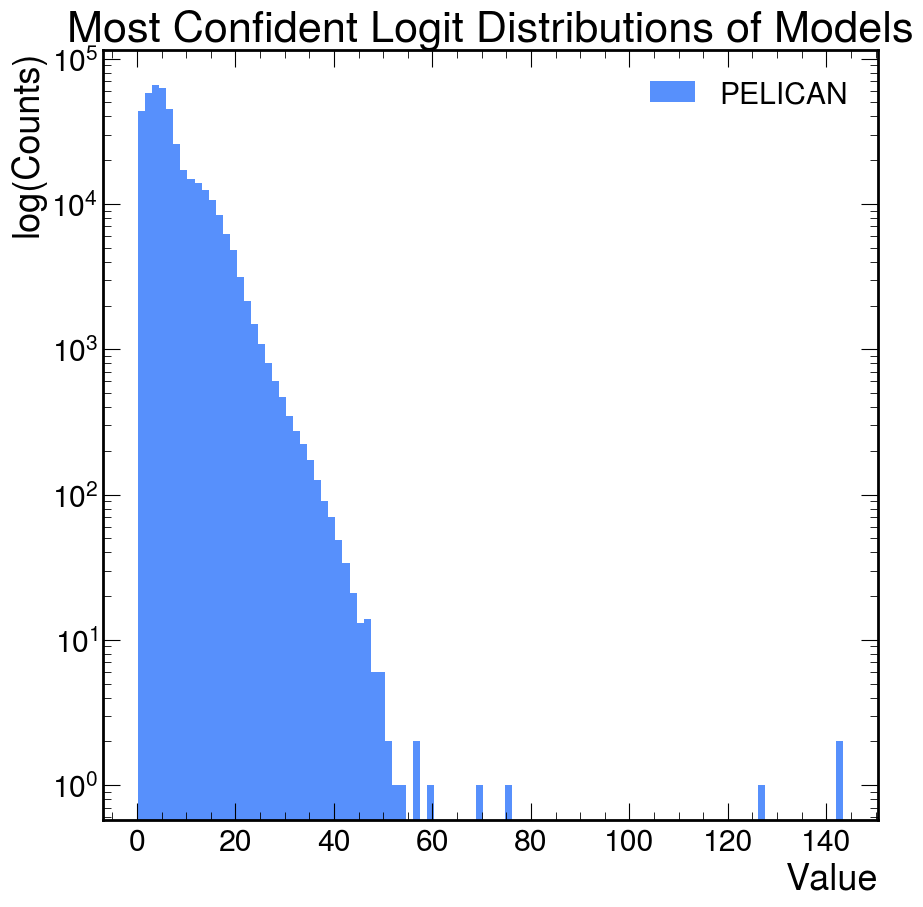

In [44]:
fig, axes = plt.subplots()

axes.set_title('Most Confident Logit Distributions of Models')
axes.set_xlabel('Value')
axes.set_ylabel('log(Counts)')
bins = 100
    
axes.hist(np.max(np_logits, axis=1), bins=bins, label='PELICAN', alpha=1)
axes.set_yscale('log')
axes.legend()

plt.show()

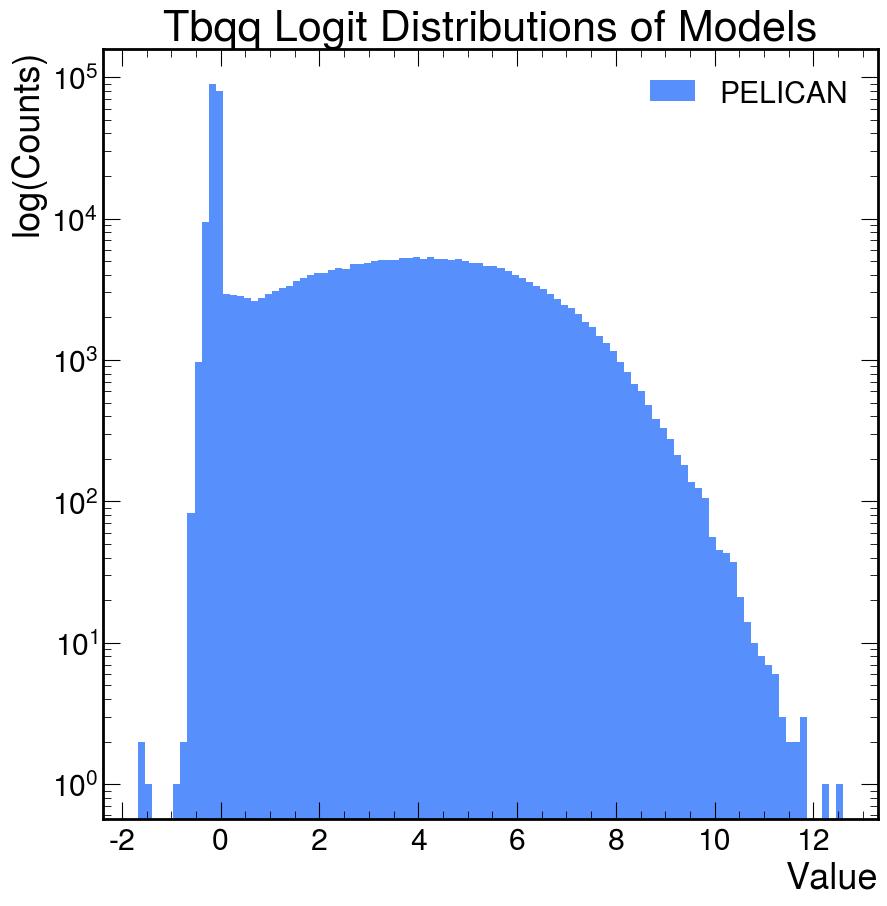

In [45]:
fig, axes = plt.subplots()

axes.set_title('Tbqq Logit Distributions of Models')
axes.set_xlabel('Value')
axes.set_ylabel('log(Counts)')
bins = 100
    
axes.hist(np_logits[:, 1], bins=bins, label='PELICAN', alpha=1)
axes.set_yscale('log')
axes.legend()

plt.show()

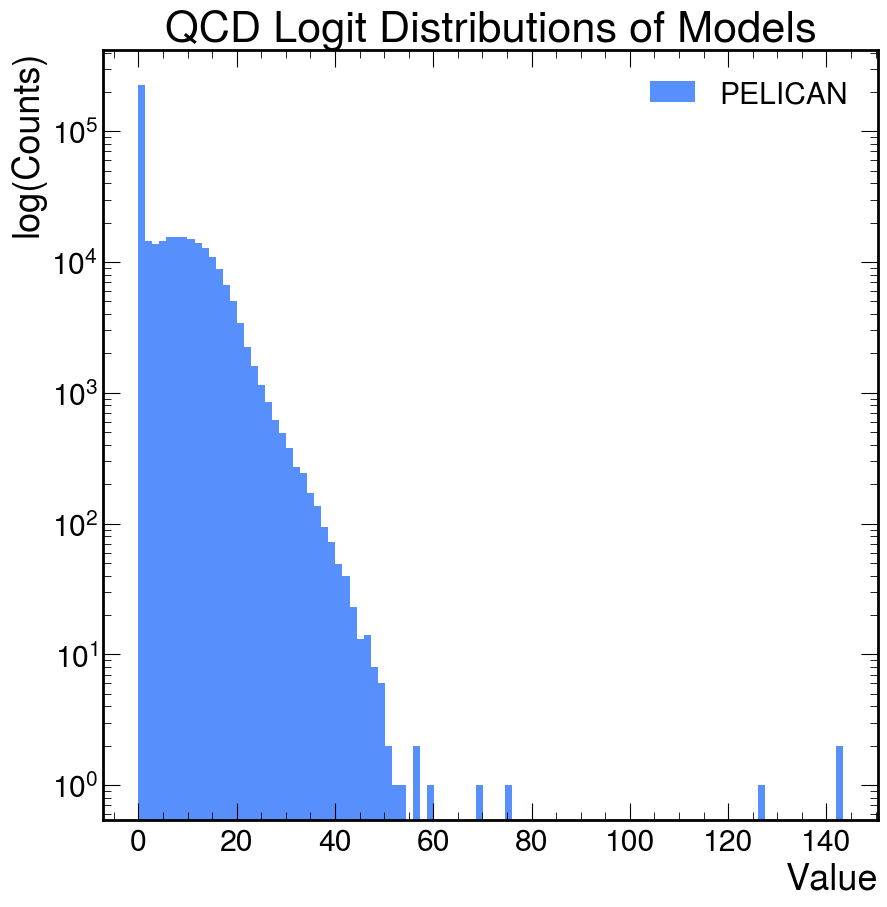

In [46]:
fig, axes = plt.subplots()

axes.set_title('QCD Logit Distributions of Models')
axes.set_xlabel('Value')
axes.set_ylabel('log(Counts)')
bins = 100
    
axes.hist(np_logits[:, 0], bins=bins, label='PELICAN', alpha=1)
axes.set_yscale('log')
axes.legend()

plt.show()

In [91]:
args = Args(
    data_train = datasets['train'],
    data_val = datasets['val'],
    data_test = datasets['test'],
    data_config = yaml_config,
    num_epochs = 5,
    batch_size = 64,
    model_prefix = workdir + '/models/torch_saved/student_models/',
    file_fraction = 1,
    data_fraction = 0.01,
    start_lr=1e-03,
    optimizer='ranger',
)

In [92]:
train_loader, val_loader, data_config, train_input_names, train_label_names = train_load(args)

In [93]:
metadata = initialize_models(network_path, yaml_config, training=True)

In [94]:
model = copy.deepcopy(metadata['model']).to(device)
loss_func = metadata['loss']

In [95]:
# optimizer & learning rate
opt, scheduler = optim(args, model, device)

In [96]:
training_handler = {}

In [97]:
def kd_loop(kl_weight, temp, class_weight=1.0):

    model = copy.deepcopy(metadata['model']).to(device)
    opt, scheduler = optim(args, model, device)
    
    tb = None
    
    # training loop
    best_valid_metric = np.inf if args.regression_mode else 0
    grad_scaler = torch.amp.GradScaler("cuda")

    trial_name = 'Alpha = ' + str(kl_weight) + ', T = ' + str(temp)
    training_handler[trial_name] = {
        'Avg Accuracy': [],
        'ROC AUC': [],
        'CCE Losses': []
    }

    hyp_config = '_' + str(kl_weight).replace('.', '') + '_' + str(temp).replace('.', '')
    if class_weight == 0:
        print('KD Only!')
        hyp_config += '_kdonly'
    
    for epoch in range(args.num_epochs):
        if args.load_epoch is not None:
            if epoch <= args.load_epoch:
                continue
        _logger.info('-' * 50)
        _logger.info('Epoch #%d training' % epoch)
        knowledge_distillation(teacher_model, model, loss_func, opt, scheduler, train_loader, device, epoch, T=temp, kl_weight=kl_weight, class_weight=class_weight,
              steps_per_epoch=args.steps_per_epoch, grad_scaler=grad_scaler, tb_helper=tb)
        
        # if args.backend is not None and local_rank == 0:
        # TODO: save checkpoint
        #     save_checkpoint()

        hook_manager = {
    'forward_hooks': {
        'logits': 'fc'
    }}

        _logger.info('Epoch #%d validating' % epoch)
        valid_metric, valid_scores, valid_labels, valid_observers = evaluate_classification(model, val_loader, device, epoch, for_training=False, loss_func=loss_func,
                                steps_per_epoch=args.steps_per_epoch_val, tb_helper=tb)

        training_handler[trial_name]['Avg Accuracy'].append(valid_metric)
        training_handler[trial_name]['ROC AUC'].append(roc_auc_score(valid_labels['_label_'], valid_scores[:,1], labels=[0,1]))
        training_handler[trial_name]['CCE Losses'].append(log_loss(valid_labels['_label_'], valid_scores, labels=[0, 1]))

        is_best_epoch = (
            valid_metric < best_valid_metric) if args.regression_mode else(
            valid_metric > best_valid_metric)
        if is_best_epoch:
            if args.model_prefix and (args.backend is None or local_rank == 0):
                dirname = os.path.dirname(args.model_prefix)
                if dirname and not os.path.exists(dirname):
                    os.makedirs(dirname)
                state_dict = model.module.state_dict() if isinstance(
                    model, (torch.nn.DataParallel, torch.nn.parallel.DistributedDataParallel)) else model.state_dict()
                torch.save(state_dict, args.model_prefix + 'ParT_student' + hyp_config + '_epoch-%d_state.pt' % epoch)
                torch.save(opt.state_dict(), args.model_prefix + 'ParT_student' + hyp_config + '_epoch-%d_optimizer.pt' % epoch)
        
        _logger.info('Epoch #%d: Current validation metric: %.5f (best: %.5f)' %
                     (epoch, valid_metric, best_valid_metric), color='bold')

In [98]:
kl_weights = [1]
temps = [7]

In [99]:
for wt in kl_weights:
    for temp in temps:
        if wt == 0 and temp != 1:
            continue
        print(f'Starting! T = {temp}, Alpha = {wt}')
        kd_loop(wt, temp, class_weight=1.0)

'''
for temp in temps:
    print(f'Starting! T = {temp}, KD Only!')
    kd_loop(1, temp, class_weight=0)
'''

Starting! T = 7, Alpha = 1


0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
3125it [03:42, 14.04it/s, lr=1.00e-03, Loss=0.38797, AvgLoss=0.43547, Acc=0.93750, AvgAcc=0.90369]
0it [00:00, ?it/s]

=== Restarting DataIter val, seed=None ===


156it [00:02, 58.68it/s, Loss=0.18454, AvgLoss=0.20163, Acc=0.90625, AvgAcc=0.91587]
ERROR:weaver:y should be a 1d array, got an array of shape (9984, 2) instead.
0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
3125it [03:56, 13.20it/s, lr=1.00e-03, Loss=0.20664, AvgLoss=0.30555, Acc=0.95312, AvgAcc=0.91473]
0it [00:00, ?it/s]

=== Restarting DataIter val, seed=None ===


156it [00:02, 64.57it/s, Loss=0.10169, AvgLoss=0.19862, Acc=0.98438, AvgAcc=0.91687]
ERROR:weaver:y should be a 1d array, got an array of shape (9984, 2) instead.
0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
3125it [04:00, 12.97it/s, lr=1.00e-03, Loss=0.34284, AvgLoss=0.28470, Acc=0.89062, AvgAcc=0.91627]
0it [00:00, ?it/s]

=== Restarting DataIter val, seed=None ===


156it [00:02, 63.01it/s, Loss=0.13328, AvgLoss=0.18615, Acc=0.93750, AvgAcc=0.92298]
ERROR:weaver:y should be a 1d array, got an array of shape (9984, 2) instead.
0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
3125it [03:53, 13.36it/s, lr=1.00e-03, Loss=0.29540, AvgLoss=0.26553, Acc=0.90625, AvgAcc=0.91966]
0it [00:00, ?it/s]

=== Restarting DataIter val, seed=None ===


156it [00:02, 60.47it/s, Loss=0.09353, AvgLoss=0.19269, Acc=0.96875, AvgAcc=0.92278]
ERROR:weaver:y should be a 1d array, got an array of shape (9984, 2) instead.
0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
3125it [03:54, 13.34it/s, lr=1.00e-05, Loss=0.19922, AvgLoss=0.24403, Acc=0.92188, AvgAcc=0.92119]
0it [00:00, ?it/s]

=== Restarting DataIter val, seed=None ===


156it [00:02, 61.15it/s, Loss=0.19304, AvgLoss=0.18417, Acc=0.89062, AvgAcc=0.92488]
ERROR:weaver:y should be a 1d array, got an array of shape (9984, 2) instead.


"\nfor temp in temps:\n    print(f'Starting! T = {temp}, KD Only!')\n    kd_loop(1, temp, class_weight=0)\n"

In [153]:
training_handler

{'Alpha = 0, T = 1': {'Avg Accuracy': [0.9409054487179487,
   0.942207532051282,
   0.9449118589743589,
   0.9489182692307693,
   0.9509214743589743],
  'ROC AUC': [0.9846792775886105,
   0.9867834202505829,
   0.9875058261308011,
   0.9881499081462886,
   0.9893466164452868],
  'CCE Losses': [0.15807142903996482,
   0.14990871399600486,
   0.14048911891574858,
   0.13499729405543326,
   0.1302875860099223]},
 'Alpha = 0.01, T = 0.1': {'Avg Accuracy': [0.9425080128205128,
   0.9452123397435898,
   0.9447115384615384,
   0.9529246794871795,
   0.9502203525641025],
  'ROC AUC': [0.9855869746396708,
   0.9875981779810376,
   0.9870668063720385,
   0.988506610576923,
   0.9887448322765142],
  'CCE Losses': [0.15239043155856927,
   0.1472957387485692,
   0.14234954700724428,
   0.1324583970440325,
   0.13186084524301492]},
 'Alpha = 0.01, T = 1': {'Avg Accuracy': [0.9435096153846154,
   0.9429086538461539,
   0.9467147435897436,
   0.9472155448717948,
   0.9507211538461539],
  'ROC AUC': [0

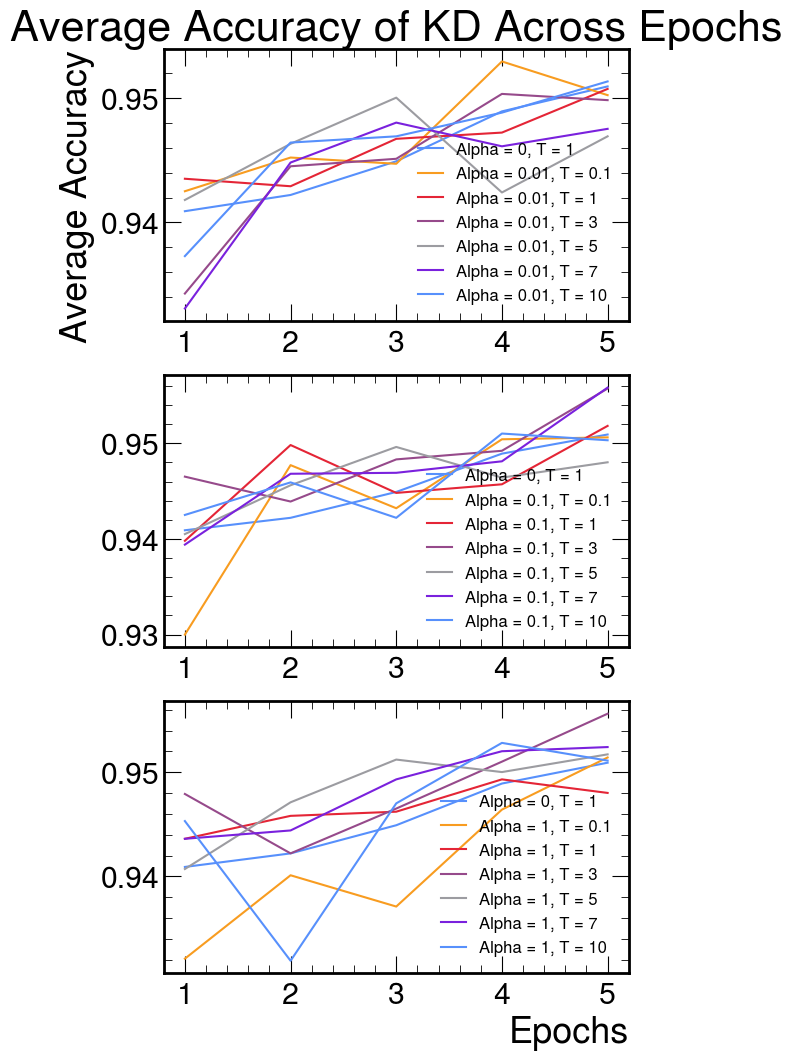

In [155]:
plt.style.use(mh.style.ROOT)
epochs = np.arange(1, args.num_epochs + 1)


fig, axes = plt.subplots(nrows=3, figsize=(6, 12))

axes[0].set_title('Average Accuracy of KD Across Epochs')
axes[-1].set_xlabel('Epochs')
axes[0].set_ylabel('Average Accuracy')

for trial, metrics in training_handler.items():
    if 'Alpha = 0.01' in trial:
        axes[0].plot(epochs, metrics['Avg Accuracy'], label=trial)
    elif 'Alpha = 0.1' in trial:
        axes[1].plot(epochs, metrics['Avg Accuracy'], label=trial)
    elif 'Alpha = 1' in trial:
        axes[2].plot(epochs, metrics['Avg Accuracy'], label=trial)
    elif 'Alpha = 3' in trial:
        continue
    else:
        for ax in axes:
            ax.plot(epochs, metrics['Avg Accuracy'], label=trial)

for ax in axes:
    ax.legend(loc='best', fontsize='12') 
plt.show()

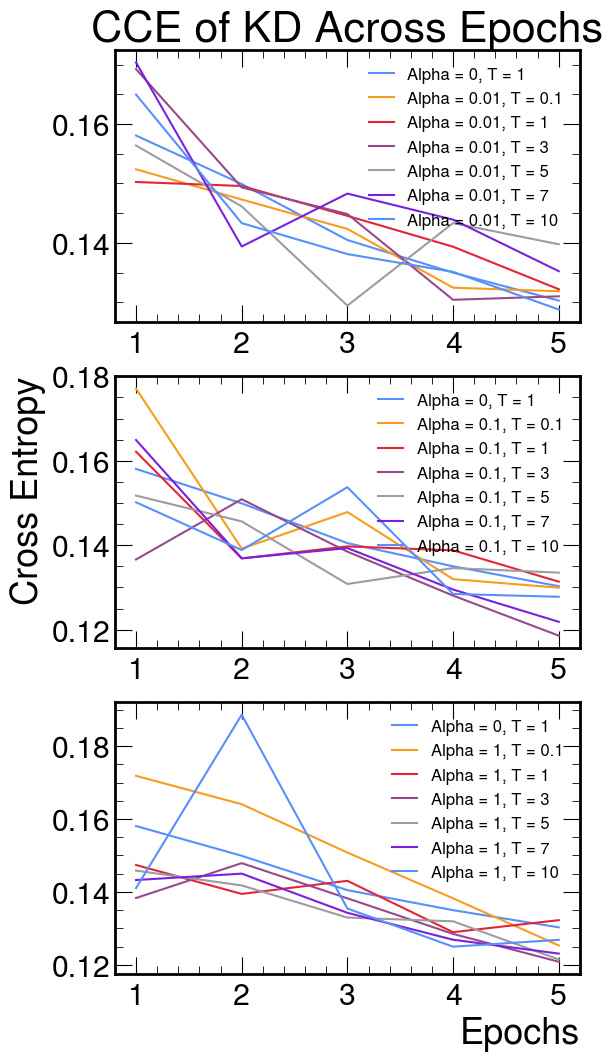

In [156]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 12))

axes[0].set_title('CCE of KD Across Epochs')
axes[2].set_xlabel('Epochs')
axes[1].set_ylabel('Cross Entropy')

for trial, metrics in training_handler.items():
    if 'Alpha = 0.01' in trial:
        axes[0].plot(epochs, metrics['CCE Losses'], label=trial)
    elif 'Alpha = 0.1' in trial:
        axes[1].plot(epochs, metrics['CCE Losses'], label=trial)
    elif 'Alpha = 1' in trial:
        axes[2].plot(epochs, metrics['CCE Losses'], label=trial)
    elif 'Alpha = 3' in trial:
        continue
    else:
        for ax in axes:
            ax.plot(epochs, metrics['CCE Losses'], label=trial)

for ax in axes:
    ax.legend(loc='best', fontsize='12') 
plt.show()

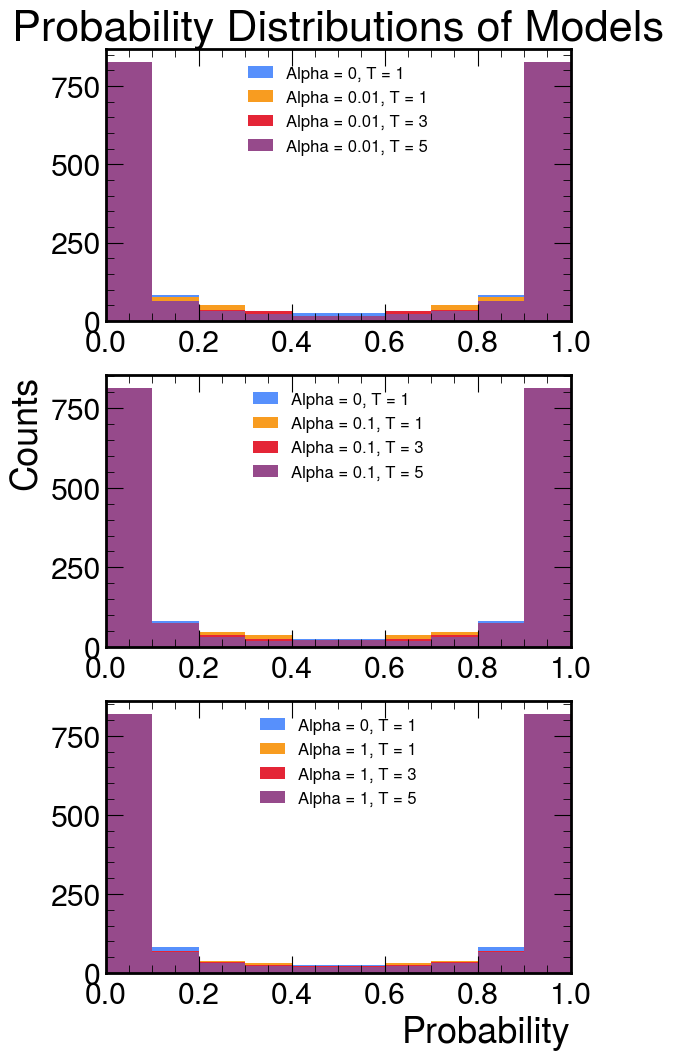

In [105]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 12))

axes[0].set_title('Probability Distributions of Models')
axes[2].set_xlabel('Probability')
axes[1].set_ylabel('Counts')

for trial, metrics in training_handler.items():
    data = metrics['Probability Distribution']
    if 'Alpha = 0.01' in trial:
        axes[0].hist(data, label=trial)
    elif 'Alpha = 0.1' in trial:
        axes[1].hist(data, label=trial)
    elif 'Alpha = 1' in trial:
        axes[2].hist(data, label=trial)
    else:
        for ax in axes:
            ax.hist(data, label=trial)

for ax in axes:
    ax.legend(loc='best', fontsize='12')
    ax.set_xlim(0, 1)
plt.show()

KeyError: 'ROC Metrics'

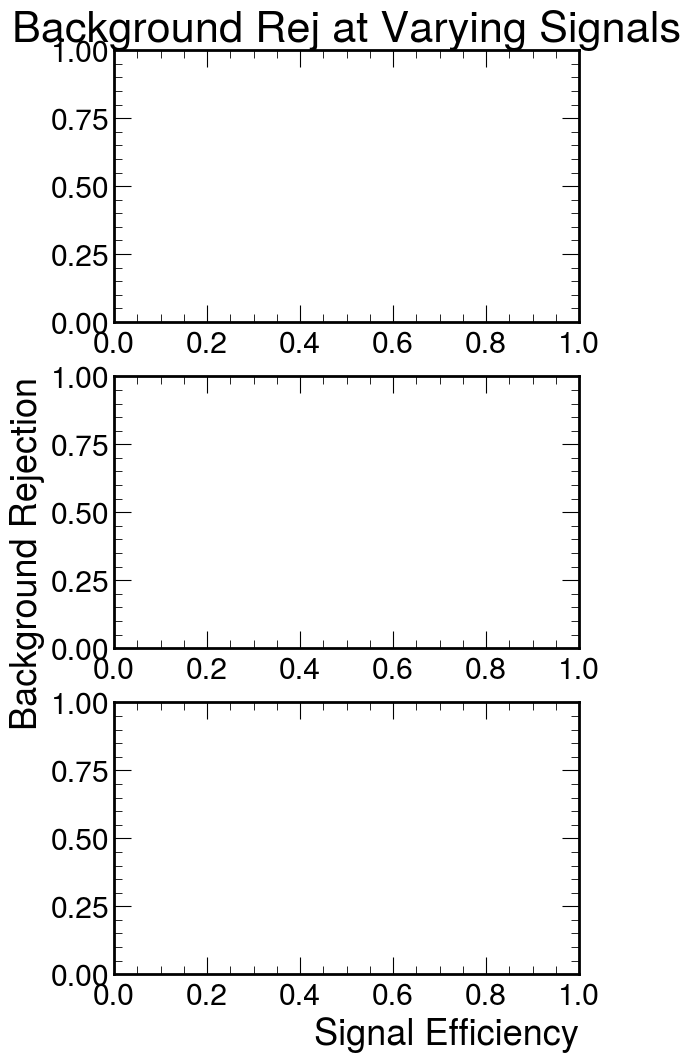

In [157]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 12))

axes[0].set_title('Background Rej at Varying Signals')
axes[2].set_xlabel('Signal Efficiency')
axes[1].set_ylabel('Background Rejection')

for trial, metrics in training_handler.items():
    signal = metrics['ROC Metrics'][1]
    fpr = metrics['ROC Metrics'][0]
    if 'Alpha = 0.01' in trial:
        axes[0].plot(signal, 1/fpr, label=trial)
    elif 'Alpha = 0.1' in trial:
        axes[1].plot(signal, 1/fpr, label=trial)
    elif 'Alpha = 1' in trial:
        axes[2].plot(signal, 1/fpr, label=trial)
    elif 'Alpha = 3' in trial:
        continue
    else:
        for ax in axes:
            ax.plot(signal, 1/fpr, label=trial)

for ax in axes:
    ax.legend(loc='best', fontsize='12')
    ax.set_yscale('log')
plt.show()

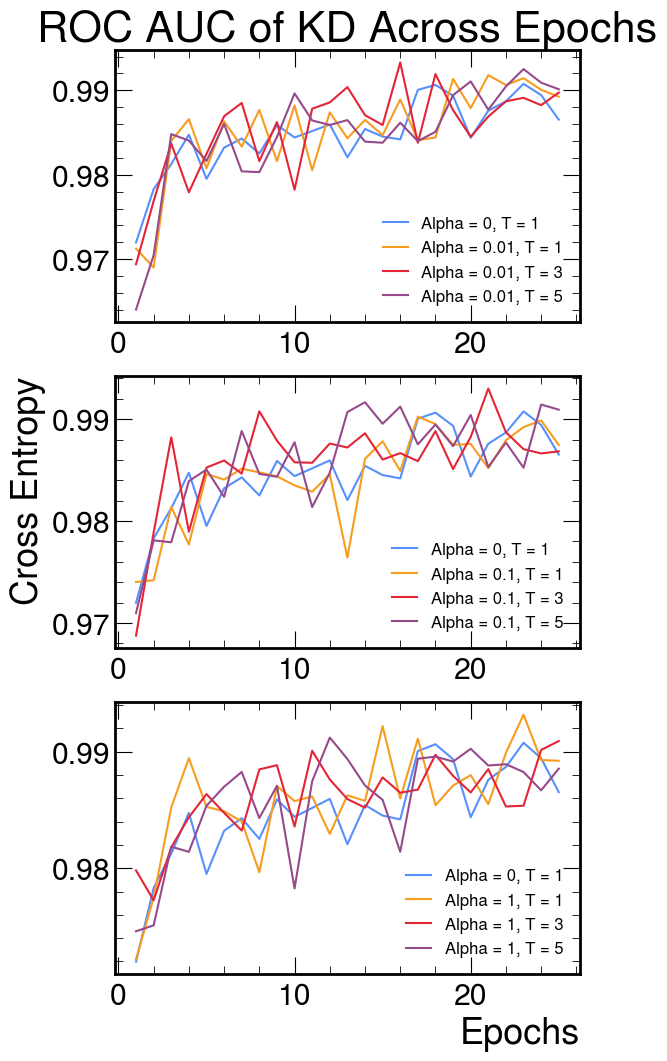

In [111]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 12))

axes[0].set_title('ROC AUC of KD Across Epochs')
axes[2].set_xlabel('Epochs')
axes[1].set_ylabel('Cross Entropy')

for trial, metrics in training_handler.items():
    data = metrics['ROC AUC']
    if 'Alpha = 0.01' in trial:
        axes[0].plot(epochs, data, label=trial)
    elif 'Alpha = 0.1' in trial:
        axes[1].plot(epochs, data, label=trial)
    elif 'Alpha = 1' in trial:
        axes[2].plot(epochs, data, label=trial)
    else:
        for ax in axes:
            ax.plot(epochs, data, label=trial)

for ax in axes:
    ax.legend(loc='best', fontsize='12') 
plt.show()

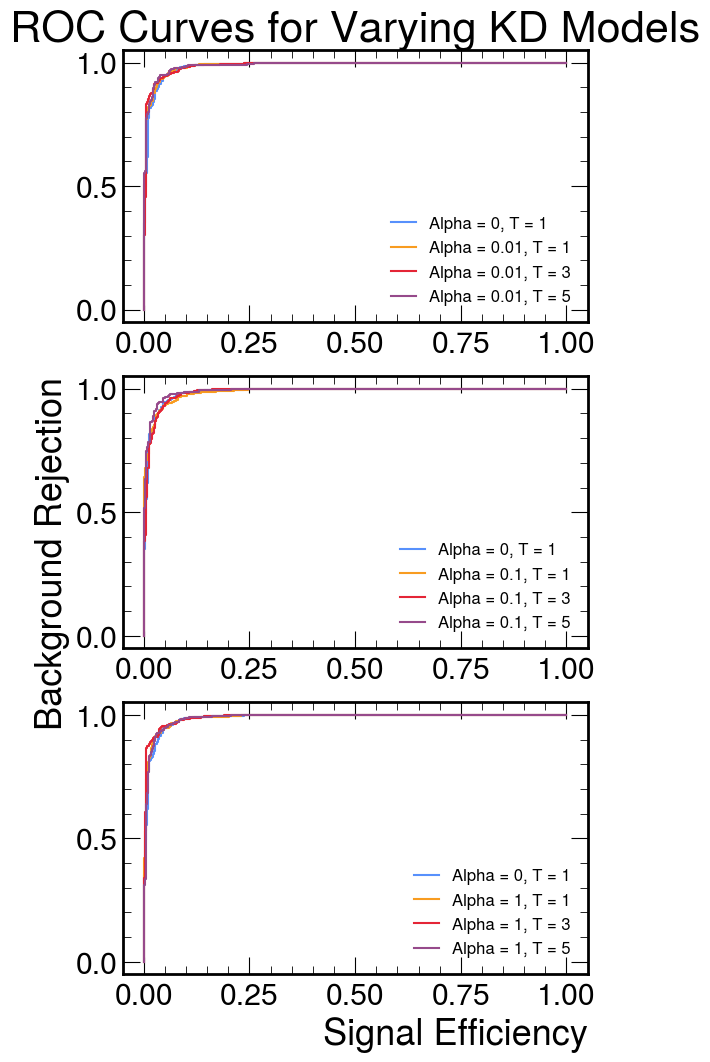

In [115]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 12))

axes[0].set_title('ROC Curves for Varying KD Models')
axes[2].set_xlabel('Signal Efficiency')
axes[1].set_ylabel('Background Rejection')

for trial, metrics in training_handler.items():
    tpr = metrics['ROC Metrics'][1]
    fpr = metrics['ROC Metrics'][0]
    if 'Alpha = 0.01' in trial:
        axes[0].plot(fpr, tpr, label=trial)
    elif 'Alpha = 0.1' in trial:
        axes[1].plot(fpr, tpr, label=trial)
    elif 'Alpha = 1' in trial:
        axes[2].plot(fpr, tpr, label=trial)
    else:
        for ax in axes:
            ax.plot(fpr, tpr, label=trial)

for ax in axes:
    ax.legend(loc='best', fontsize='12')
plt.show()

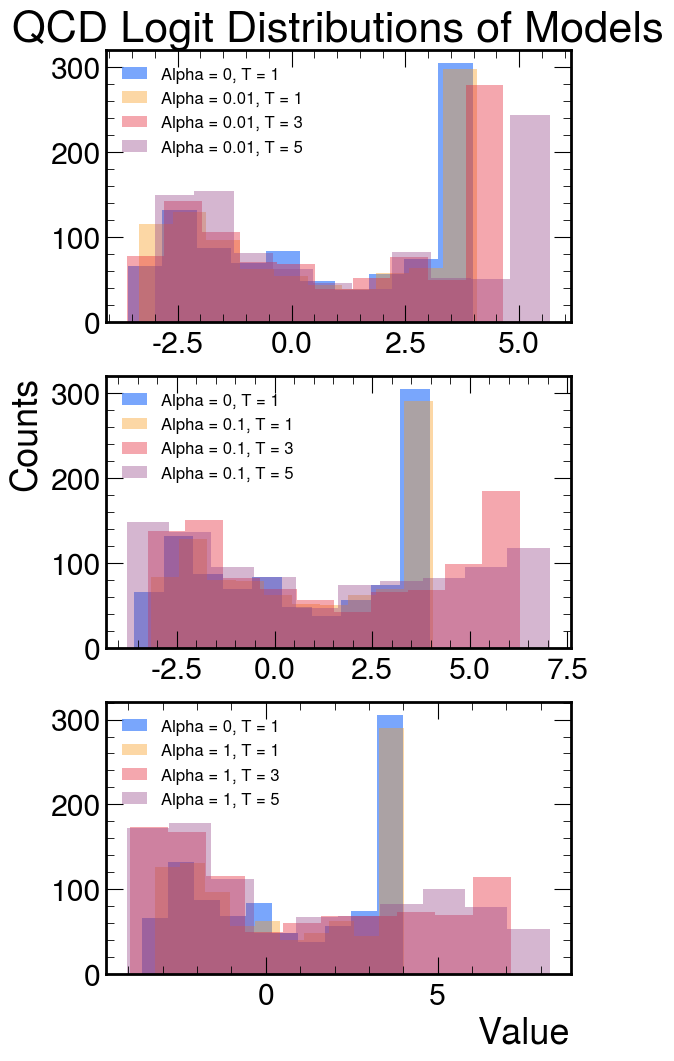

In [133]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 12))

axes[0].set_title('QCD Logit Distributions of Models')
axes[2].set_xlabel('Value')
axes[1].set_ylabel('Counts')

for trial, metrics in training_handler.items():
    qcd = metrics['Logit Distribution'][0::2]
    top = metrics['Logit Distribution'][1::2]
    if 'Alpha = 0.01' in trial:
        axes[0].hist(qcd, label=trial, alpha = 0.4)
    elif 'Alpha = 0.1' in trial:
        axes[1].hist(qcd, label=trial, alpha = 0.4)
    elif 'Alpha = 1' in trial:
        axes[2].hist(qcd, label=trial, alpha = 0.4)
    else:
        for ax in axes:
            ax.hist(qcd, label=trial, alpha = 0.8)

for ax in axes:
    ax.legend(loc='best', fontsize='12')
plt.show()

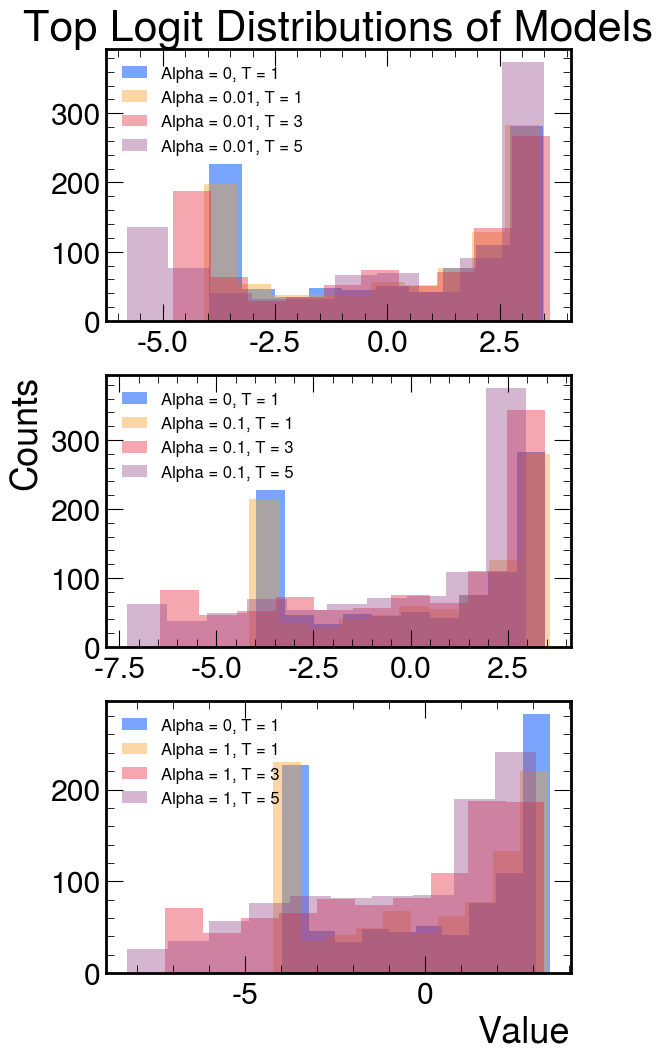

In [134]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 12))

axes[0].set_title('Top Logit Distributions of Models')
axes[2].set_xlabel('Value')
axes[1].set_ylabel('Counts')

for trial, metrics in training_handler.items():
    qcd = metrics['Logit Distribution'][0::2]
    top = metrics['Logit Distribution'][1::2]
    if 'Alpha = 0.01' in trial:
        axes[0].hist(top, label=trial, alpha = 0.4)
    elif 'Alpha = 0.1' in trial:
        axes[1].hist(top, label=trial, alpha = 0.4)
    elif 'Alpha = 1' in trial:
        axes[2].hist(top, label=trial, alpha = 0.4)
    else:
        for ax in axes:
            ax.hist(top, label=trial, alpha = 0.8)

for ax in axes:
    ax.legend(loc='best', fontsize='12')
plt.show()

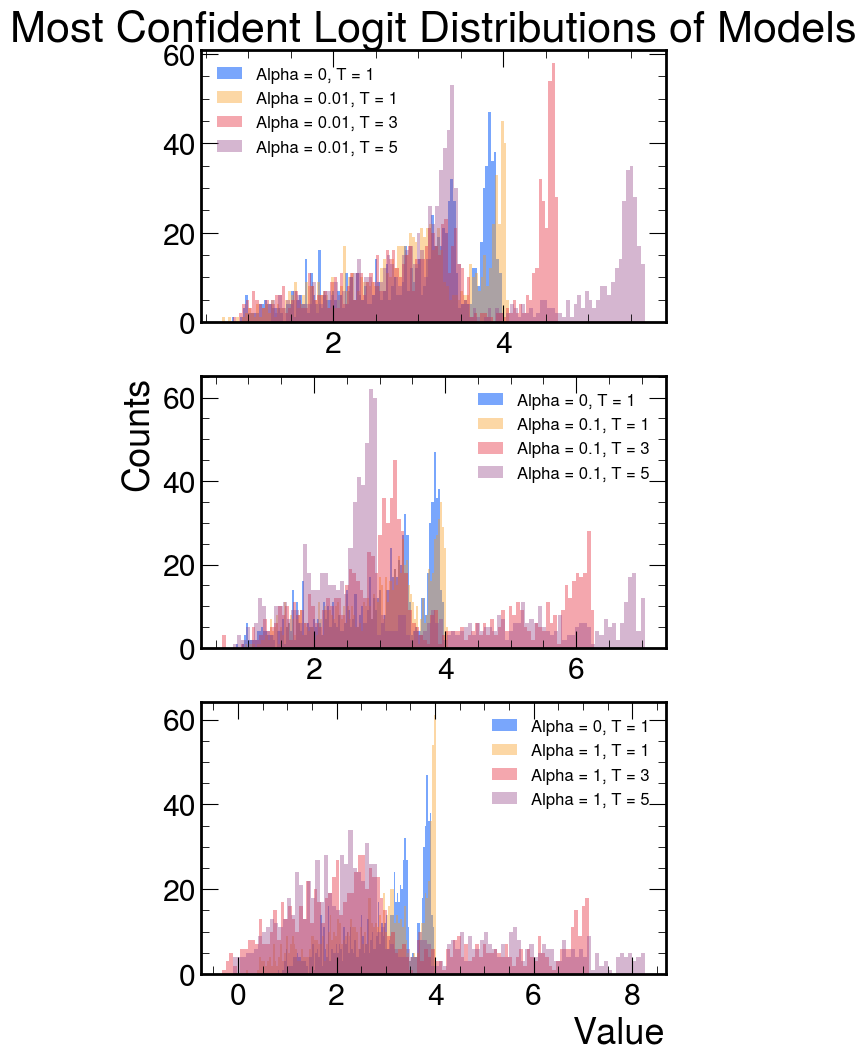

In [146]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 12))

axes[0].set_title('Most Confident Logit Distributions of Models')
axes[2].set_xlabel('Value')
axes[1].set_ylabel('Counts')
bins = 100

for trial, metrics in training_handler.items():
    data = metrics['Logit Distribution'].reshape(-1, 2)
    most_confident = np.max(data, axis=1)
    if 'Alpha = 0.01' in trial:
        axes[0].hist(most_confident, bins=bins, label=trial, alpha = 0.4)
    elif 'Alpha = 0.1' in trial:
        axes[1].hist(most_confident, bins=bins, label=trial, alpha = 0.4)
    elif 'Alpha = 1' in trial:
        axes[2].hist(most_confident, bins=bins, label=trial, alpha = 0.4)
    else:
        for ax in axes:
            ax.hist(most_confident, bins=bins, label=trial, alpha = 0.8)

for ax in axes:
    ax.legend(loc='best', fontsize='12')
plt.show()

In [137]:
top_variances = {}
qcd_variances = {}
probability_variances = {}
final_auc = {}

for trial, metrics in training_handler.items():
    data = metrics['Logit Distribution'][0::2]
    qcd_variances[trial] = np.var(data)
    data = metrics['Logit Distribution'][1::2]
    top_variances[trial] = np.var(data)
    data = metrics['Probability Distribution']
    probability_variances[trial] = np.var(data)
    data = metrics['ROC AUC'][args.num_epochs-1]
    final_auc[trial] = data

In [151]:
model = PySRRegressor.from_file(run_directory='/home/alang/ppCodes/part_gp/outputs/pysr_outputs/sr_tests/20251224_195611_qzQwUY')

Attempting to load model from /home/alang/ppCodes/part_gp/outputs/pysr_outputs/sr_tests/20251224_195611_qzQwUY/checkpoint.pkl...
INFO:pysr.sr:Attempting to load model from /home/alang/ppCodes/part_gp/outputs/pysr_outputs/sr_tests/20251224_195611_qzQwUY/checkpoint.pkl...


In [ ]:
print(model)

In [153]:
modules = model.pytorch([28, 26])

In [155]:
symbolic_model = TestNN((1, 272, 1), modules).to(device)

In [169]:
with torch.no_grad():
    symbolic_model.eval()
    symbolic_preds=symbolic_model(torch.from_numpy(new_df.to_numpy()).to(device))

In [170]:
symbolic_preds

[tensor([-0.7784, -0.9454, -1.3020,  ...,  2.1832,  4.2665, -1.4460],
        device='cuda:0'),
 tensor([ 2.3802,  1.3759,  2.7505,  ..., -1.7587, -4.3848,  1.9149],
        device='cuda:0')]

In [171]:
symbolic_preds_np = torch.cat([tensor.unsqueeze(1) for tensor in symbolic_preds], dim=1).detach().cpu().numpy()

In [172]:
symbolic_preds_np

array([[-0.77836776,  2.380199  ],
       [-0.9454213 ,  1.3758558 ],
       [-1.3019946 ,  2.7504508 ],
       ...,
       [ 2.1831598 , -1.7587495 ],
       [ 4.266519  , -4.3847604 ],
       [-1.4460185 ,  1.9148848 ]], dtype=float32)

In [176]:
concat_logits = torch.cat(new_outputs['forward_hooks']['logits']).cpu().numpy()

In [207]:
symbolic_logits = {}

for i in range(1, 32+1):
    modules = model.pytorch([i, i])

    symbolic_model = TestNN((1, 272, 1), modules).to(device)

    with torch.no_grad():
        symbolic_model.eval()
        symbolic_preds=symbolic_model(torch.from_numpy(new_df.to_numpy()).to(device))
    symbolic_preds_np = torch.cat([tensor.unsqueeze(1) for tensor in symbolic_preds], dim=1).detach().cpu().numpy()

    symbolic_logits[f'Model Complexity {i}'] = np.max(symbolic_preds_np, axis=1)

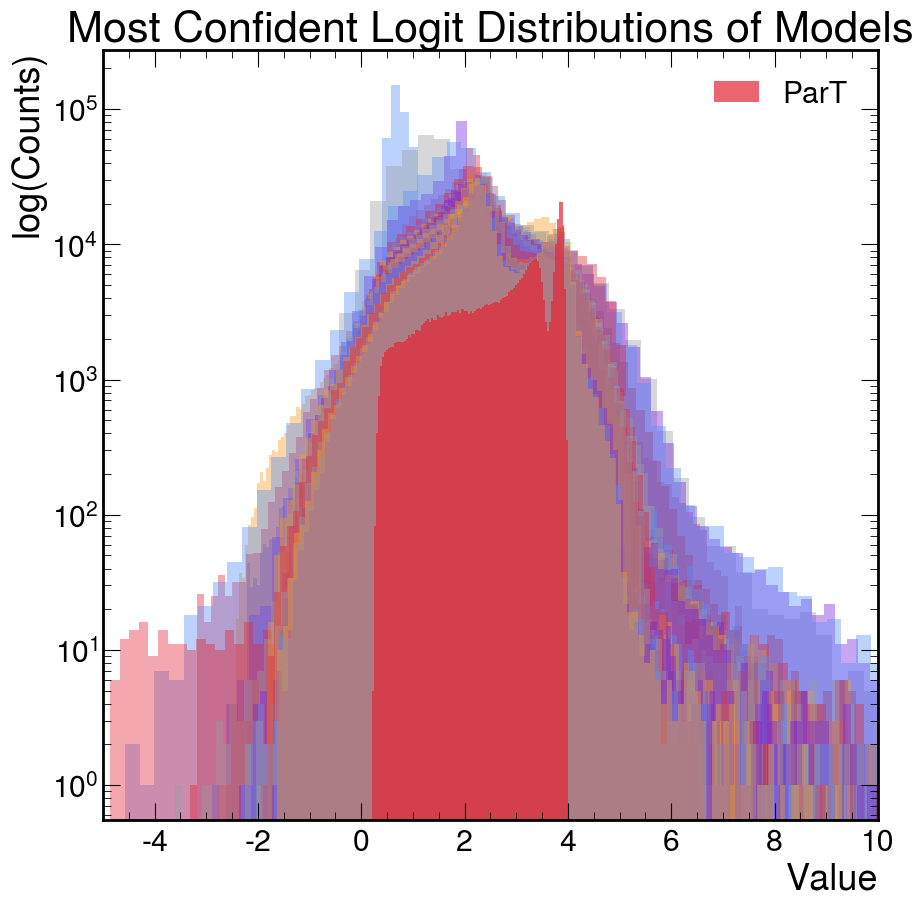

In [208]:
fig, axes = plt.subplots()

axes.set_title('Most Confident Logit Distributions of Models')
axes.set_xlabel('Value')
axes.set_ylabel('log(Counts)')
bins = 100

for complexity, distribution in symbolic_logits.items():
    axes.hist(distribution, bins=bins, alpha=0.4)
    
axes.hist(np.max(concat_logits, axis=1), bins=bins, label='ParT', alpha=0.7)
axes.set_xlim(-5, 10)
axes.set_yscale('log')
axes.legend()

plt.show()

In [209]:
symbolic_logits = {}

modules = model.pytorch([28, 26])

symbolic_model = TestNN((1, 272, 1), modules).to(device)

with torch.no_grad():
    symbolic_model.eval()
    symbolic_preds=symbolic_model(torch.from_numpy(new_df.to_numpy()).to(device))
symbolic_preds_np = torch.cat([tensor.unsqueeze(1) for tensor in symbolic_preds], dim=1).detach().cpu().numpy()

symbolic_logits[f'Model Complexity {i}'] = np.max(symbolic_preds_np, axis=1)

NameError: name 'symbolic_logits' is not defined

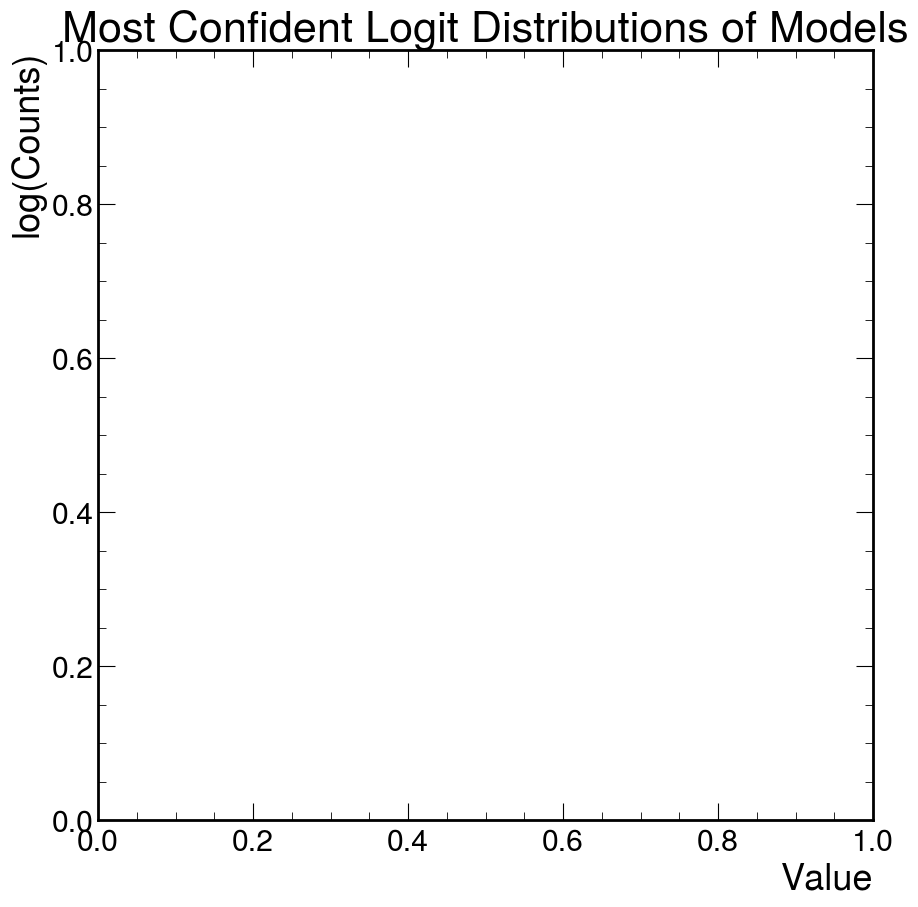

In [73]:
fig, axes = plt.subplots()

axes.set_title('Most Confident Logit Distributions of Models')
axes.set_xlabel('Value')
axes.set_ylabel('log(Counts)')
bins = 100

for complexity, distribution in symbolic_logits.items():
    axes.hist(distribution, bins=bins, alpha=0.7, label = 'Symbolic Model')
    
axes.hist(np.max(concat_logits, axis=1), bins=bins, label='ParT', alpha=0.7)
axes.set_xlim(-5, 10)
#axes.set_yscale('log')
axes.legend()

plt.show()

In [19]:
# Working on Pairwise Interaction Features

weights_path = workdir + '/models/torch_saved/student_models/ParT_student_1_7_epoch-4_state.pt'  

pred_metadata = initialize_models(network_path, yaml_config, training=False, model_path = weights_path)

pred_model = copy.deepcopy(pred_metadata['model']).to(device)

pred_args = Args(
    data_test = datasets['train'],
    data_config = yaml_config,
    batch_size = 64,
    file_fraction = 1,
    data_fraction = 0.01
)

test_loaders, data_config = test_load(pred_args)

hook_manager = {
    'forward_hooks': {
        'logits': 'fc',
    },
    'pre_forward_hooks': {
        'inputs': 'trimmer'
    }
}

handles, outputs = HookHandler(pred_model, hook_manager).registration(safety_remove = True)


Removing all hooks within the model

Forward Hook Registered: logits

Forward Hook Registered: inputs


In [18]:
outputs['pre_forward_hooks']['pairwise'] = []

pairwise_hook = pred_model.mod.pair_embed.embed.register_forward_pre_hook(HookHandler.save_inputs('pairwise', outputs['pre_forward_hooks']))

In [20]:
test_loaders, data_config = test_load(pred_args)

for name, get_test_loader in test_loaders.items():
    
    test_loader = get_test_loader()
    
    test_metric, scores, labels, observers = evaluate_classification(pred_model, test_loader, device, epoch=None, for_training=False)
    
    del test_loader

0it [00:00, ?it/s]

=== Restarting DataIter test_, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
1it [00:02,  2.02s/it, Loss=0.00000, AvgLoss=0.00000, Acc=0.92188, AvgAcc=0.92188]/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

In [22]:
np_logits = torch.cat(outputs['forward_hooks']['logits']).cpu().numpy()

In [23]:
inputs = outputs['pre_forward_hooks']['inputs']

In [12]:
outputs['pre_forward_hooks']['pairwise'][0][0].shape

torch.Size([64, 4, 136])

In [13]:
concat_inputs = []

for v in range(3):
    if inputs[0][v] is None:
        continue
    
    concat_inputs.append(
        torch.cat(
            [inputs[i][v].cpu() for i in range(len(inputs))],
            dim=0
        ).numpy()
    )

In [14]:
mask_indices = np.array([i for i, arr in enumerate(concat_inputs[2]) if 0 in arr]) # Array of indices of jets that have 0 in their padding mask array

nonpadded_mask = np.ones(40000, dtype=bool)
nonpadded_mask[mask_indices] = False

In [15]:
pw_int = outputs['pre_forward_hooks']['pairwise']

In [16]:
flattened_batches = []

for iteration in pw_int:
    tensor = iteration[0]
    
    batch_flattened = tensor.reshape(64, -1) 
    
    target_pairwise_len = 16 * 17 // 2
    target_features = 4 * target_pairwise_len 
    
    current_features = batch_flattened.shape[1]
    
    if current_features < target_features:
        padding = torch.zeros(64, target_features - current_features, 
                             device=batch_flattened.device, 
                             dtype=batch_flattened.dtype)
        batch_flattened = torch.cat([batch_flattened, padding], dim=1)
    elif current_features > target_features:
        batch_flattened = batch_flattened[:, :target_features]
    
    flattened_batches.append(batch_flattened)

In [17]:
concat_inputs[0].shape

(40000, 7, 16)

In [18]:
primary_features = concat_inputs[0].reshape(40000, 7 * 16)[nonpadded_mask]
pairwise_features = torch.cat(flattened_batches, dim=0).detach().cpu().numpy()[nonpadded_mask]

In [19]:
x = np.concatenate((primary_features, pairwise_features), axis=1)

In [20]:
x.shape

(38265, 656)

In [21]:
feature_names = data_config.input_dicts['pf_features']
pairwise_names = ['lnkt', 'lnz', 'lndelta', 'lnm2']

columns = []

for feature in feature_names:
    for particle in range(16):
        columns.append(f"{feature}_p{particle}")

i, j = torch.tril_indices(16, 16, offset=0)
i, j = i.numpy(), j.numpy()

for pairwise in pairwise_names:
    for interaction in range(16*17 // 2):
        p1, p2 = i[interaction], j[interaction]
        columns.append(f"{pairwise}_{p1}{p2}")

df = pd.DataFrame(x, columns=columns)

In [22]:
df

,part_pt_log_p0,part_pt_log_p1,part_pt_log_p2,part_pt_log_p3,part_pt_log_p4,part_pt_log_p5,part_pt_log_p6,part_pt_log_p7,part_pt_log_p8,part_pt_log_p9,...,lnm2_156,lnm2_157,lnm2_158,lnm2_159,lnm2_1510,lnm2_1511,lnm2_1512,lnm2_1513,lnm2_1514,lnm2_1515
0,1.618245,1.494649,1.364509,1.309848,1.238187,1.238151,1.196505,1.092519,0.963153,0.949288,...,2.954030,-0.965966,2.863637,0.529737,-0.650140,2.770007,2.477248,-0.627709,-0.825006,-2.552575
1,1.765289,1.757913,1.391385,1.338780,1.274976,1.190119,1.150530,1.119835,1.091751,1.080000,...,5.287217,5.163738,4.944325,5.143703,5.004938,4.856413,4.759974,4.749848,1.558813,-2.552575
2,2.199227,1.698390,1.599285,1.473597,1.380566,1.169708,1.095266,0.907448,0.745474,0.589446,...,3.987301,-0.844697,-2.166098,-2.173581,-1.668458,1.922488,-0.731343,3.017468,2.906729,-9.298595
3,2.212025,1.296213,1.243683,1.242171,1.143831,1.090527,1.057665,0.992485,0.920992,0.908078,...,2.281415,3.961506,-0.113504,1.710304,3.844785,3.535414,2.169514,3.127573,3.308510,-2.551792
4,2.070024,1.734139,1.553592,1.412128,1.354191,1.319530,1.205366,1.097655,1.024262,0.866893,...,3.327502,2.965646,4.653593,2.754901,4.369774,4.366470,3.834869,-0.161256,2.622706,-0.025343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38260,2.365970,2.297753,1.954442,1.289595,1.072495,0.952524,0.882113,0.662266,0.447891,-0.170269,...,-2.999034,-1.647475,-2.951206,-0.734089,-4.035258,0.533280,-3.970719,-2.832645,0.826883,-13.169796
38261,1.842265,1.797912,1.768512,1.709743,1.319249,1.226571,0.973464,0.827147,0.784809,0.703144,...,-0.723637,-2.487351,-1.579318,-1.677564,-0.637533,-2.213531,-1.791088,-2.151561,-1.356174,-2.551987
38262,2.410418,2.080534,1.711262,1.079969,1.003534,1.001341,0.876867,0.688712,0.662560,0.374268,...,1.381829,1.597786,0.290433,0.274604,0.718132,0.842951,-0.421655,0.093483,1.525669,-0.025421
38263,2.437884,1.702298,1.695783,1.646791,1.527804,1.005515,0.749871,0.464109,0.448371,0.357670,...,-0.508326,-0.450134,1.526462,-0.951163,1.200403,-1.466449,-0.775718,-1.999361,0.241756,-18.420681


In [9]:
class ParticleFlowNetwork(nn.Module):
    r"""Parameters
    ----------
    input_dims : int
        Input feature dimensions.
    num_classes : int
        Number of output classes.
    layer_params : list
        List of the feature size for each layer.
    """

    def __init__(self, input_dims, num_classes,
                 Phi_sizes=(100, 100, 128),
                 F_sizes=(100, 100, 100),
                 use_bn=True,
                 for_inference=False,
                 **kwargs):

        super(ParticleFlowNetwork, self).__init__(**kwargs)
        # input bn
        self.input_bn = nn.BatchNorm1d(input_dims) if use_bn else nn.Identity()
        # per-particle functions
        phi_layers = []
        for i in range(len(Phi_sizes)):
            phi_layers.append(nn.Sequential(
                nn.Conv1d(input_dims if i == 0 else Phi_sizes[i - 1], Phi_sizes[i], kernel_size=1),
                nn.BatchNorm1d(Phi_sizes[i]) if use_bn else nn.Identity(),
                nn.ReLU())
            )
        self.phi = nn.Sequential(*phi_layers)
        # global functions
        f_layers = []
        for i in range(len(F_sizes)):
            f_layers.append(nn.Sequential(
                nn.Linear(Phi_sizes[-1] if i == 0 else F_sizes[i - 1], F_sizes[i]),
                nn.ReLU())
            )
        f_layers.append(nn.Linear(F_sizes[-1], num_classes))
        if for_inference:
            f_layers.append(nn.Softmax(dim=1))
        self.fc = nn.Sequential(*f_layers)

    def forward(self, points, features, lorentz_vectors, mask):
        # x: the feature vector initally read from the data structure, in dimension (N, C, P)
        x = self.input_bn(features)
        x = self.phi(x)
        if mask is not None:
            x = x * mask.bool().float()
        x = x.sum(-1)
        return self.fc(x)


def get_model(data_config, **kwargs):
    Phi_sizes = (128, 128, 128)
    F_sizes = (128, 128, 128)
    input_dims = len(data_config.input_dicts['pf_features'])
    num_classes = len(data_config.label_value)
    model = ParticleFlowNetwork(input_dims, num_classes, Phi_sizes=Phi_sizes,
                                F_sizes=F_sizes, use_bn=kwargs.get('use_bn', False))

    model_info = {
        'input_names': list(data_config.input_names),
        'input_shapes': {k: ((1,) + s[1:]) for k, s in data_config.input_shapes.items()},
        'output_names': ['softmax'],
        'dynamic_axes': {**{k: {0: 'N', 2: 'n_' + k.split('_')[0]} for k in data_config.input_names}, **{'softmax': {0: 'N'}}},
    }

    return model, model_info


def get_loss(data_config, **kwargs):
    return torch.nn.CrossEntropyLoss()

In [12]:
data_config = SimpleIterDataset({}, yaml_config, for_training=True).config
modules, model_info = get_model(data_config)

In [14]:
model = copy.deepcopy(modules)

In [28]:
len(inputs)

3125

In [35]:
len(inputs[0][0][0][0])

16

In [36]:
concat_inputs = []

for v in range(3):
    if inputs[0][v] is None:
        continue
    
    concat_inputs.append(
        torch.cat(
            [inputs[i][v].cpu() for i in range(len(inputs))],
            dim=0
        ).numpy()
    )

In [ ]:
if isinstance(inputs, list):
    inputs_tensor = torch.stack(concat_inputs)  # or torch.cat if they're already compatible
elif isinstance(inputs, np.ndarray):
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
else:
    inputs_tensor = inputs  # already a tensor

# Convert targets to tensor
if isinstance(targets, np.ndarray):
    targets_tensor = torch.tensor(targets, dtype=torch.float32)  # or torch.long for classification
else:
    targets_tensor = targets

# Create dataset and dataloader
dataset = TensorDataset(inputs_tensor, targets_tensor)
dataloader = DataLoader(
    dataset, 
    batch_size=32,  # adjust as needed
    shuffle=True,   # shuffle for training
    num_workers=4,  # for parallel data loading (0 if on Windows or debugging)
    pin_memory=True  # faster GPU transfer if using CUDA
)

# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    
    for batch_inputs, batch_targets in dataloader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')